In [1]:
%matplotlib inline
%load_ext lab_black

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import missingno as msno
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
import tensorflow as tf
import IPython
from sklearn.base import BaseEstimator, RegressorMixin, clone

from shared import process_single_site, compute_metrics
from plot import (
    plot_timeline,
    plot_desity_and_errors,
    pred_plot,
    error_per_month_and_year,
)
from shared import HistoryKerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from tensorflow import keras
from model import eval_model, make_grid, hyperparam_graph, hyperparam_plot

resources = "resources/"
metadata_path = os.path.join(resources, "fdk_site_info.csv")
data_path = os.path.join(resources, "full_time_series.csv.gz")

# Temporal models

## Data preparation

Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Dropping unused features
Removing bad values
Adding engineered features
Remove unused features
NA: 48


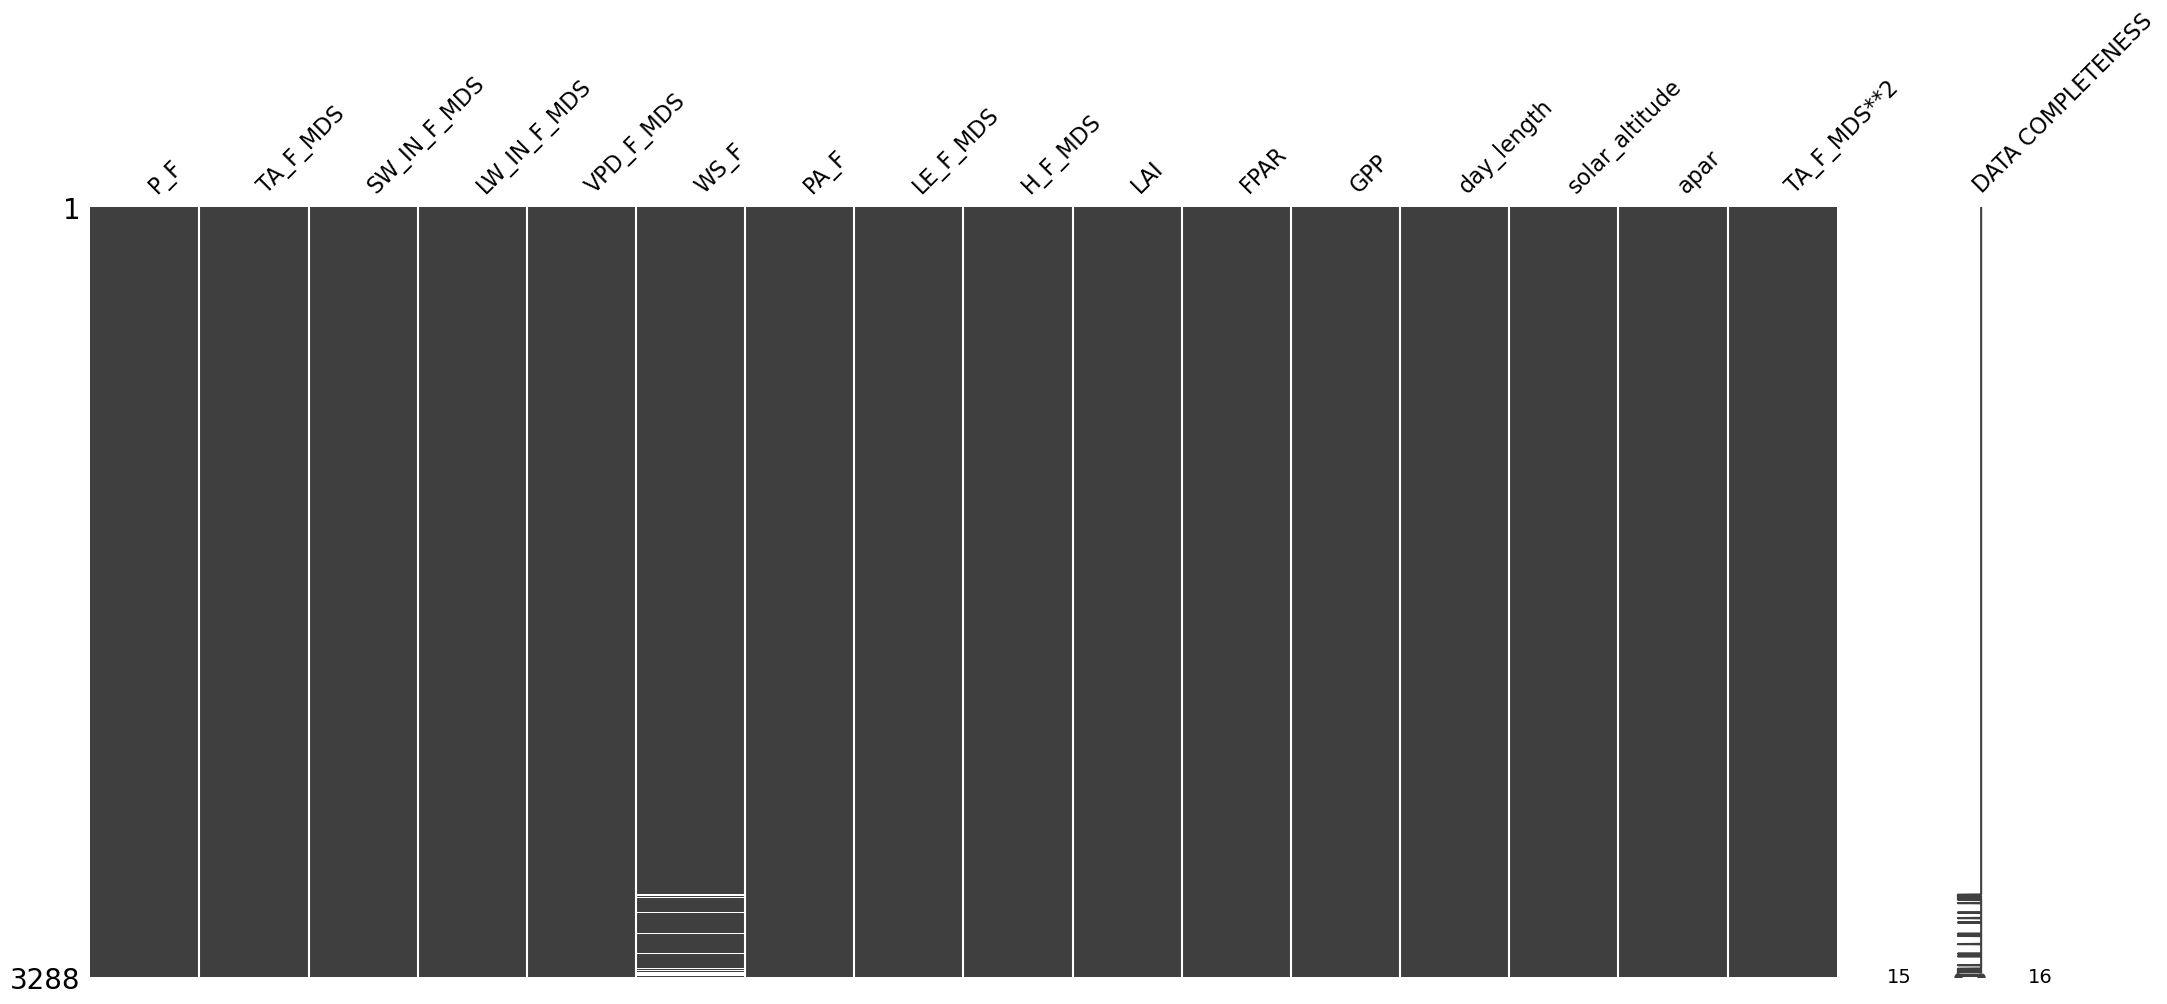

In [2]:
df = process_single_site(data_path, metadata_path, with_rolling_windows=False)

In [3]:
df["WS_F"].fillna(df["WS_F"].mean(), inplace=True)
print(f"NA: {(df.isna().any(axis=1)).sum()}")
df.describe()

NA: 0


P_F     TA_F_MDS  SW_IN_F_MDS  LW_IN_F_MDS    VPD_F_MDS  \
count  3288.000000  3288.000000  3288.000000  3288.000000  3288.000000   
mean      1.819885     8.260147   133.012296   312.002634     3.471603   
std       4.701352     8.525756    99.745974    37.762339     4.127888   
min       0.000000   -16.758769     2.477104   164.047645     0.000000   
25%       0.000000     1.445646    41.625740   288.986129     0.280719   
50%       0.060000     8.222416   114.776843   313.728490     1.739125   
75%       1.350000    14.937395   216.516703   338.596183     5.553781   
max      77.180000    27.885918   365.312354   399.349187    24.105375   

              WS_F         PA_F     LE_F_MDS      H_F_MDS          LAI  \
count  3288.000000  3288.000000  3288.000000  3288.000000  3288.000000   
mean      2.393134    94.050362    27.472868    26.543071     1.403614   
std       0.742924     0.752386    25.410383    45.966570     0.867032   
min       0.661083    90.156208   -33.120516  -124.000401     0.435851   
25%       1.856995    93.601708     5.446243    -5.847220     0.754778   
50%       2.293781    94.087521    22.363811    16.991746     1.081901   
75%       2.791464    94.546146    46.943773    59.315630     1.791767   
max       5.668437    96.785229   158.647611   161.151386     4.279058   

              FPAR          GPP   day_length  solar_altitude         apar  \
count  3288.000000  3288.000000  3288.000000     3288.000000  3288.000000   
mean      0.620903     4.241806    11.996366       40.535213    91.807436   
std       0.131136     3.320416     2.795695       16.591261    78.420336   
min       0.338631    -0.887474     7.939248       17.106494     1.073743   
25%       0.521882     0.953906     9.285128       23.974738    21.455365   
50%       0.612029     4.015508    12.000000       40.556276    70.242824   
75%       0.727236     6.877861    14.708427       57.102212   152.774962   
max       0.905668    13.443908    16.060752       64.006059   316.670948   

       TA_F_MDS**2  
count  3288.000000  
mean   2499.228495  
std     841.099070  
min     587.637291  
25%    1801.632922  
50%    2422.846230  
75%    3128.992128  
max    4745.269687

In [4]:
scaler = QuantileTransformer(output_distribution="normal")
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=scaler.get_feature_names_out())

C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


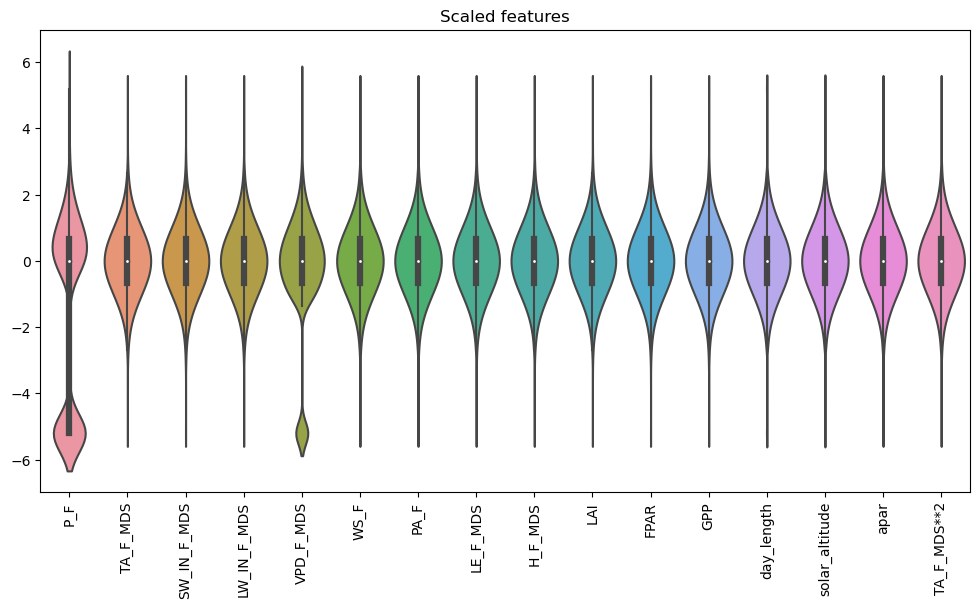

In [5]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=df_scaled)
_ = ax.set_xticklabels(df_scaled.keys(), rotation=90)
plt.title("Scaled features")
plt.show()

In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df_scaled)
train_df = df_scaled[0 : int(n * 0.7)]
val_df = df_scaled[int(n * 0.7) : int(n * 0.9)]
test_df = df_scaled[int(n * 0.9) :]

num_features = df_scaled.shape[1]

## Business logic

All the logic is adapted from https://www.tensorflow.org/tutorials/structured_data/time_series

In [7]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift=0,  # Offset following the end of the input section marking the end of the label section.
        label_columns=["GPP"],
        keep_labels=False,  # Keep label columns as input features (autocorrelation)
        batch_size=8,
        shuffle=False,
    ):
        if shift == 0 and keep_labels is True:
            raise Error("shift must be positive if keep_labels is True")

        self.keep_labels = keep_labels
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.shifted_label_indices = np.arange(self.total_window_size)[
            self.labels_slice
        ]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.shifted_label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def indep_columns(self, columns):
        return [c for c in columns if (c not in self.label_columns) or self.keep_labels]

    def column_indices(self, columns):
        return {name: i for i, name in enumerate(columns)}

    # Given a batch of consecutive inputs, convert them to a window of inputs and a window of labels.
    def split_window(self, features, columns):
        inputs = features[:, self.input_slice, :]
        shifted_labels = features[:, self.labels_slice, :]
        self.column_indices(columns)
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    inputs[:, :, self.column_indices(columns)[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )
            inputs = tf.stack(
                [
                    inputs[:, :, self.column_indices(columns)[name]]
                    for name in self.indep_columns(columns)
                ],
                axis=-1,
            )
            shifted_labels = tf.stack(
                [
                    shifted_labels[:, :, self.column_indices(columns)[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.input_width, None])
        shifted_labels.set_shape([None, self.label_width, None])

        return inputs, labels, shifted_labels

    # Predict window n of first batch only
    # Attention, not NaN padded!
    def predict(
        self,
        data,
        model,
        n=0,
        plot_col=None,
        is_baseline=False,
    ):
        if plot_col is None:
            plot_col = self.label_columns[0]
        inputs, labels, shifted_labels = next(iter(self.make_dataset_intern(data)))
        if is_baseline:
            inputs = labels
        label_col_index = self.label_columns_indices.get(plot_col, None)

        predictions = model(inputs)
        return predictions[n, :, label_col_index].numpy()

    # Plot first batch only (and at most max_subplots windows)
    def plot(
        self,
        data,
        model=None,
        plot_col=None,
        max_subplots=1,
        is_baseline=False,
    ):
        if plot_col is None:
            plot_col = self.label_columns[0]
        inputs, labels, shifted_labels = next(iter(self.make_dataset_intern(data)))
        if is_baseline:
            inputs = labels
        plt.figure(figsize=(12, 8))
        label_col_index = self.label_columns_indices.get(plot_col, None)
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                labels[n, :, label_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if model is None:
                plt.scatter(
                    self.shifted_label_indices,
                    shifted_labels[n, :, label_col_index],
                    edgecolors="k",
                    label="Labels",
                    c="#2ca02c",
                    s=64,
                )
            else:
                predictions = model(inputs)
                plt.scatter(
                    self.shifted_label_indices,
                    predictions[n, :, label_col_index],
                    # marker="X",
                    # edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=16,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Day")
        plt.show()

    # Create an iterator yielding batches of random windows
    def make_dataset_intern(self, data):
        columns = data.columns
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=self.shuffle,
            batch_size=self.batch_size,
        )

        ds = ds.map(lambda f: self.split_window(f, columns))

        return ds

    def make_dataset(self, data, return_labels_as_feature=False):
        if return_labels_as_feature:
            return self.make_dataset_intern(data).map(lambda x, y, z: (y, z))
        else:
            return self.make_dataset_intern(data).map(lambda x, y, z: (x, z))

In [8]:
w = WindowGenerator(input_width=6, label_width=3, shift=1)
w

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [4 5 6]
Label column name(s): ['GPP']

In [9]:
# Stack two slices, the length of the total window.
example_window = tf.stack(
    [
        np.array(train_df[: w.total_window_size]),
        np.array(train_df[100 : 100 + w.total_window_size]),
        # np.array(train_df[200 : 200 + w.total_window_size]),
    ]
)

example_inputs, example_labels, _ = w.split_window(example_window, train_df)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (2, 7, 16)
Inputs shape: (2, 6, 15)
Labels shape: (2, 6, 1)


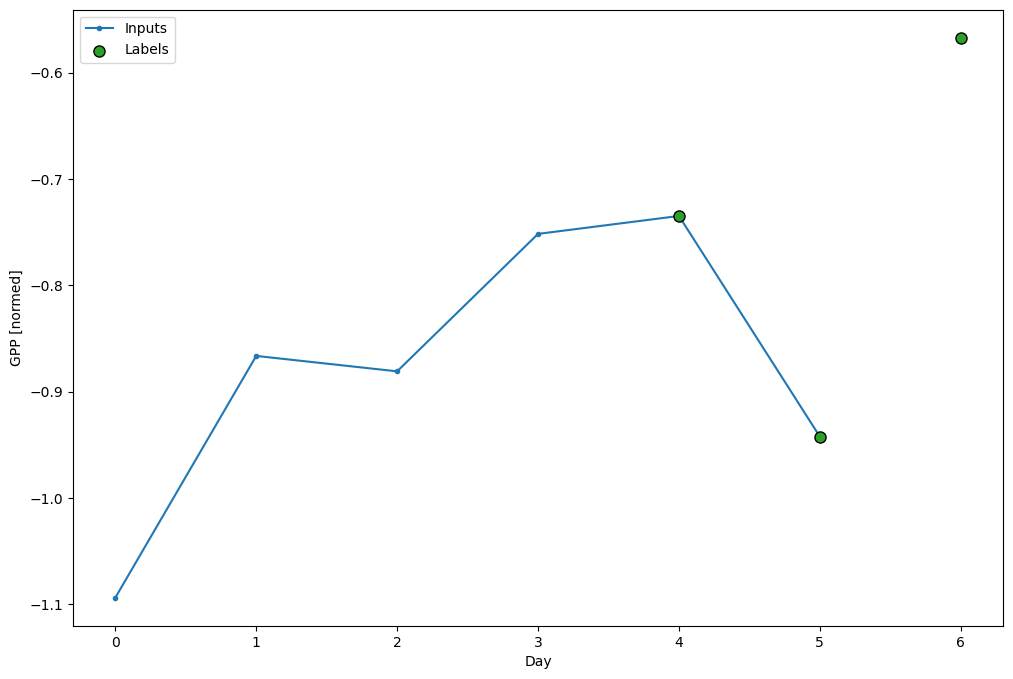

In [10]:
w.plot(test_df)

In [11]:
# Take the first 2 batches
batches = w.make_dataset(train_df)
for example_inputs, example_labels in batches.take(2):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

print(
    f"Note that there are {len(batches)} batches because there are {train_df.shape[0]} samples gathered by batches of {w.batch_size} samples"
)

Inputs shape (batch, time, features): (8, 6, 15)
Labels shape (batch, time, features): (8, 3, 1)
Inputs shape (batch, time, features): (8, 6, 15)
Labels shape (batch, time, features): (8, 3, 1)
Note that there are 287 batches because there are 2301 samples gathered by batches of 8 samples


In [12]:
def plot_curves(history):
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title(
        "Validation loss {:.3f}".format(np.mean(history.history["val_loss"][-3:]))
    )
    plt.xlabel("epoch")
    plt.ylabel("loss value")
    plt.legend()
    plt.show()

In [13]:
def compile_and_fit(model, window, learning_rate=0.001, max_epochs=100, patience=6):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.make_dataset(train_df),
        epochs=max_epochs,
        validation_data=window.make_dataset(val_df),
        callbacks=[early_stopping],
    )
    return history

In [14]:
val_performance = {}
performance = {}


def build_and_test(name, model, window, is_baseline=False):
    if is_baseline is True:
        max_epochs = 0
    else:
        max_epochs = 100
    history = compile_and_fit(model, window, max_epochs=max_epochs)
    if max_epochs > 1:
        plot_curves(history)

    val_performance[name] = model.evaluate(
        window.make_dataset(val_df, is_baseline), return_dict=True
    )
    performance[name] = model.evaluate(
        window.make_dataset(test_df, is_baseline), verbose=0, return_dict=True
    )
    print(f"Val: {val_performance[name]}")
    print(f"Test: {performance[name]}")

In [15]:
LABEL_WIDTH = 180

In [16]:
n = len(test_df)
full_window = WindowGenerator(input_width=n, label_width=n)

## Single step models

### Baseline

In [21]:
n = len(test_df) - 1
full_shifted_window = WindowGenerator(input_width=n, label_width=n, shift=1)

In [22]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

42/42 [==============================] - 0s 1ms/step - loss: 0.1649 - mean_absolute_error: 0.2846
Val: {'loss': 0.16492977738380432, 'mean_absolute_error': 0.28455597162246704}
Test: {'loss': 0.21360813081264496, 'mean_absolute_error': 0.2956472635269165}


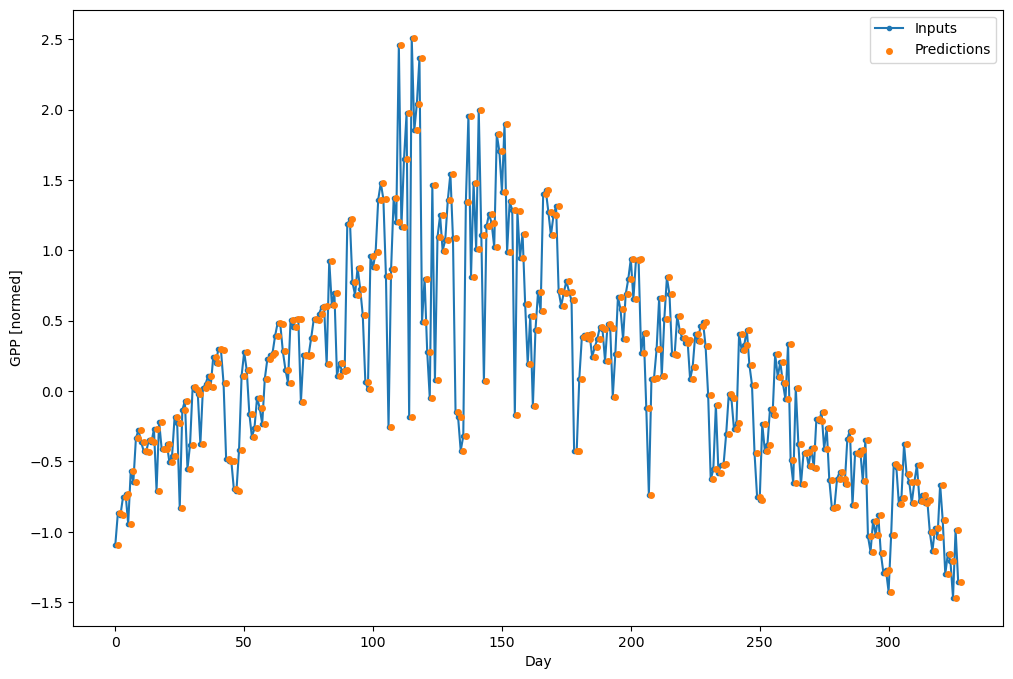

In [23]:
baseline = Baseline()
build_and_test("Baseline", baseline, full_shifted_window, is_baseline=True)
full_shifted_window.plot(test_df, baseline, is_baseline=True)

### Linear

In [24]:
single_step_window = WindowGenerator(input_width=1, label_width=1)

Epoch 1/100
288/288 [==============================] - 1s 2ms/step - loss: 2.2781 - mean_absolute_error: 1.1472 - val_loss: 1.0919 - val_mean_absolute_error: 0.7916
Epoch 2/100
288/288 [==============================] - 0s 2ms/step - loss: 0.9825 - mean_absolute_error: 0.7514 - val_loss: 0.5636 - val_mean_absolute_error: 0.5696
Epoch 3/100
288/288 [==============================] - 0s 1ms/step - loss: 0.6150 - mean_absolute_error: 0.6057 - val_loss: 0.3972 - val_mean_absolute_error: 0.4846
Epoch 4/100
288/288 [==============================] - 0s 2ms/step - loss: 0.4777 - mean_absolute_error: 0.5402 - val_loss: 0.3187 - val_mean_absolute_error: 0.4385
Epoch 5/100
288/288 [==============================] - 0s 2ms/step - loss: 0.4058 - mean_absolute_error: 0.4990 - val_loss: 0.2717 - val_mean_absolute_error: 0.4064
Epoch 6/100
288/288 [==============================] - 0s 2ms/step - loss: 0.3608 - mean_absolute_error: 0.4686 - val_loss: 0.2415 - val_mean_absolute_error: 0.3824
Epoch 7/10

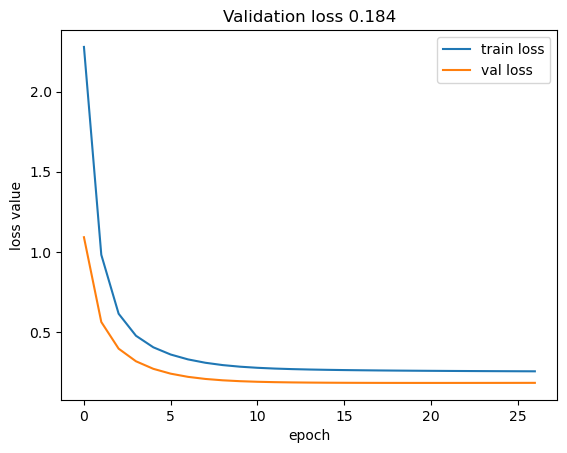

83/83 [==============================] - 0s 1ms/step - loss: 0.1842 - mean_absolute_error: 0.3213
Val: {'loss': 0.18423281610012054, 'mean_absolute_error': 0.3212798237800598}
Test: {'loss': 0.16663233935832977, 'mean_absolute_error': 0.3077316880226135}


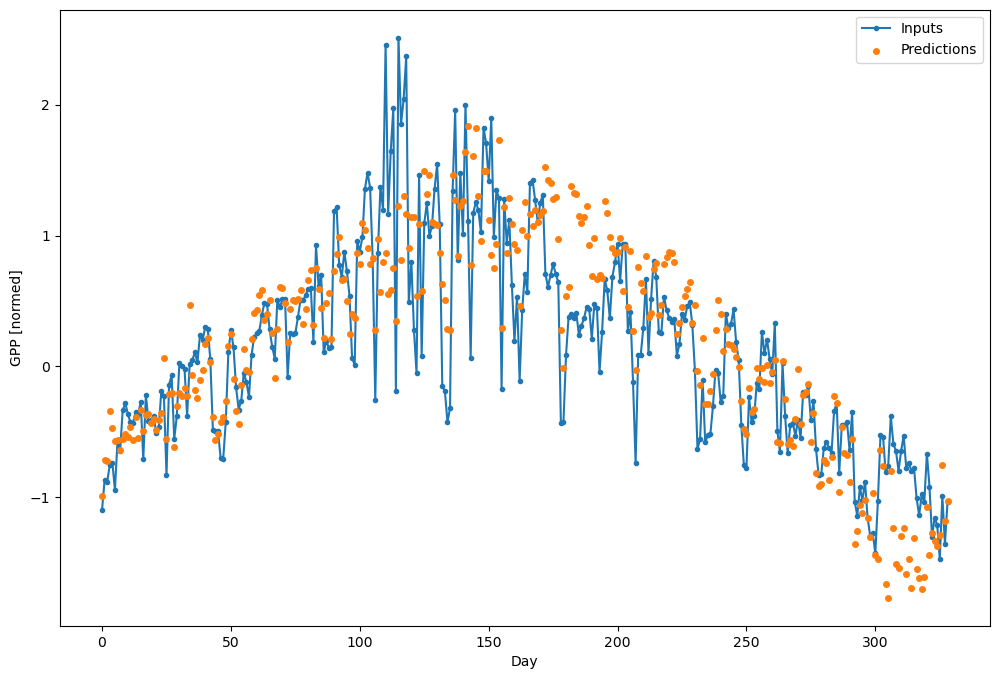

In [25]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])
build_and_test("Linear", linear, single_step_window)
full_window.plot(test_df, linear)

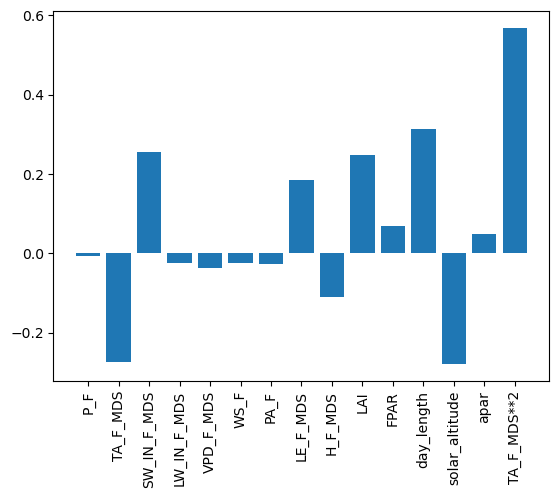

In [26]:
columns = full_window.indep_columns(test_df)
plt.bar(
    x=range(len(columns)),
    height=linear.layers[0].kernel[:, 0].numpy(),
)
axis = plt.gca()
axis.set_xticks(range(len(columns)))
_ = axis.set_xticklabels(columns, rotation=90)

## Temporal models

### CNN

In [27]:
CONV_WIDTH = 30
conv_window = WindowGenerator(input_width=CONV_WIDTH, label_width=1)
conv_window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [29]
Label column name(s): ['GPP']

In [28]:
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH)

In [29]:
KERNEL_SIZE = 30
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=KERNEL_SIZE, kernel_size=(CONV_WIDTH,), activation="relu"
        ),
        tf.keras.layers.Dense(units=KERNEL_SIZE, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

Epoch 1/100
284/284 [==============================] - 1s 2ms/step - loss: 0.6855 - mean_absolute_error: 0.6292 - val_loss: 0.5663 - val_mean_absolute_error: 0.6006
Epoch 2/100
284/284 [==============================] - 1s 2ms/step - loss: 0.4195 - mean_absolute_error: 0.4948 - val_loss: 0.9435 - val_mean_absolute_error: 0.6804
Epoch 3/100
284/284 [==============================] - 1s 2ms/step - loss: 0.4605 - mean_absolute_error: 0.5146 - val_loss: 0.6087 - val_mean_absolute_error: 0.6098
Epoch 4/100
284/284 [==============================] - 1s 2ms/step - loss: 0.3914 - mean_absolute_error: 0.4750 - val_loss: 0.7443 - val_mean_absolute_error: 0.6572
Epoch 5/100
284/284 [==============================] - 1s 2ms/step - loss: 0.4451 - mean_absolute_error: 0.4875 - val_loss: 0.8841 - val_mean_absolute_error: 0.7276
Epoch 6/100
284/284 [==============================] - 1s 2ms/step - loss: 0.5359 - mean_absolute_error: 0.5556 - val_loss: 0.8634 - val_mean_absolute_error: 0.7480
Epoch 7/10

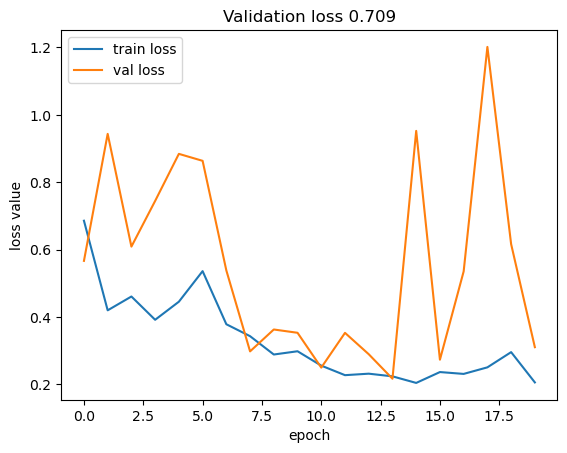

79/79 [==============================] - 0s 1ms/step - loss: 0.3101 - mean_absolute_error: 0.4241
Val: {'loss': 0.31005120277404785, 'mean_absolute_error': 0.4241471290588379}
Test: {'loss': 0.25479263067245483, 'mean_absolute_error': 0.37557974457740784}


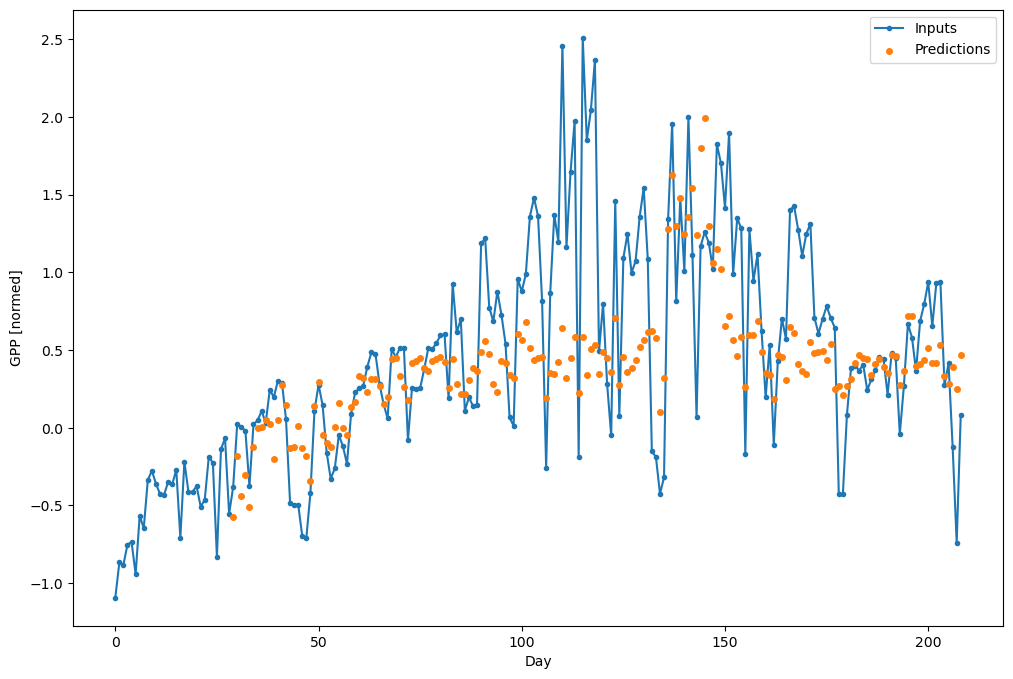

In [30]:
build_and_test("Conv", conv_model, conv_window)
wide_conv_window.plot(test_df, conv_model)

In [31]:
# wide_conv_window.predict(test_df, conv_model)

### LSTM

See here: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [32]:
LSTM_UNITS = 30

In [33]:
lstm_train_window = WindowGenerator(input_width=LSTM_UNITS, label_width=LSTM_UNITS)

In [34]:
lstm_model = tf.keras.models.Sequential(
    [
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1),
    ]
)

Epoch 1/100
284/284 [==============================] - 5s 11ms/step - loss: 0.3758 - mean_absolute_error: 0.4586 - val_loss: 0.2374 - val_mean_absolute_error: 0.3809
Epoch 2/100
284/284 [==============================] - 3s 11ms/step - loss: 0.2265 - mean_absolute_error: 0.3517 - val_loss: 0.1809 - val_mean_absolute_error: 0.3239
Epoch 3/100
284/284 [==============================] - 3s 10ms/step - loss: 0.1909 - mean_absolute_error: 0.3185 - val_loss: 0.1725 - val_mean_absolute_error: 0.3075
Epoch 4/100
284/284 [==============================] - 3s 10ms/step - loss: 0.1726 - mean_absolute_error: 0.3017 - val_loss: 0.1680 - val_mean_absolute_error: 0.2989
Epoch 5/100
284/284 [==============================] - 3s 11ms/step - loss: 0.1619 - mean_absolute_error: 0.2917 - val_loss: 0.1641 - val_mean_absolute_error: 0.2933
Epoch 6/100
284/284 [==============================] - 3s 10ms/step - loss: 0.1510 - mean_absolute_error: 0.2803 - val_loss: 0.1602 - val_mean_absolute_error: 0.2897
Epoc

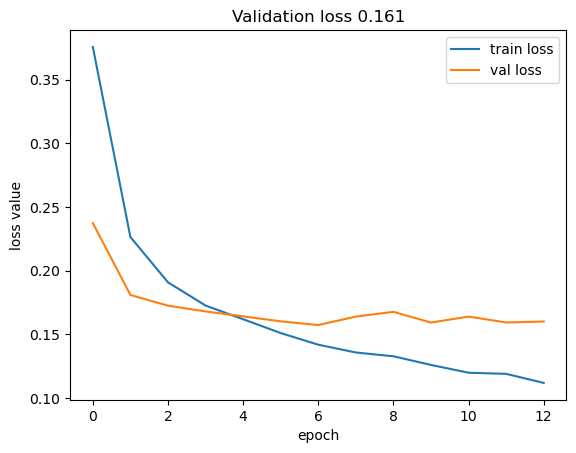

79/79 [==============================] - 0s 3ms/step - loss: 0.1601 - mean_absolute_error: 0.2923
Val: {'loss': 0.16008135676383972, 'mean_absolute_error': 0.29225432872772217}
Test: {'loss': 0.1459416151046753, 'mean_absolute_error': 0.2623826861381531}


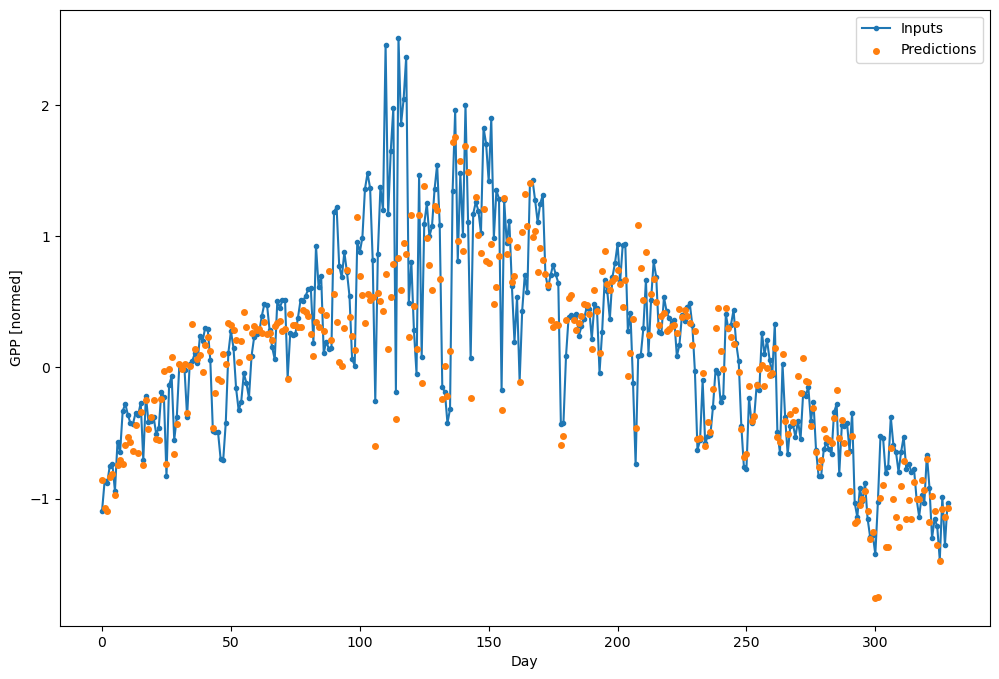

In [35]:
history = build_and_test("LSTM", lstm_model, lstm_train_window)
full_window.plot(test_df, lstm_model)

## Peformance

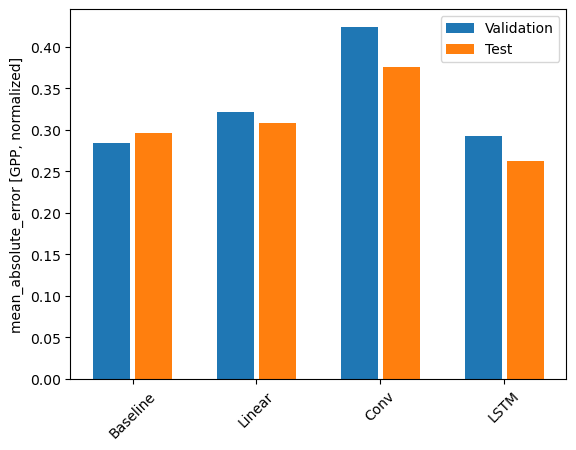

In [36]:
x = np.arange(len(performance))
width = 0.3
metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel("mean_absolute_error [GPP, normalized]")
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

## Pipeline

In [17]:
split_r = 0.8
tv_split = df[: int(len(df) * split_r)]
test_split = df[int(len(df) * split_r) :]
df_pred = pd.DataFrame()
df_pred["True GPP"] = test_split["GPP"].copy()
df_pred["baseline"] = df_pred["True GPP"]
X_tv = tv_split.drop(["GPP"], axis=1)
y_tv = tv_split["GPP"]
X_test = test_split.drop(["GPP"], axis=1)
y_test = test_split["GPP"]

In [22]:
class WindowRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self, regressor, n=1, batch_size=8, shuffle=False, validation_split=0.2
    ):
        self.regressor = regressor
        self.n = n
        self.validation_split = validation_split
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.window = WindowGenerator(n, n, batch_size=batch_size, shuffle=shuffle)

    def fit(self, X, y, verbose=False):
        X = pd.DataFrame(X)
        X["GPP"] = y
        split = 1 - self.validation_split
        test = X[: int(len(X) * split)]
        val = X[int(len(X) * split) :]
        val_batches = self.window.make_dataset(val)
        if len(val_batches) <= 0:
            raise Error(
                "Increase validation_split so that there are enough samples to fit at least one window."
            )
        self.regressor.fit(
            self.window.make_dataset(test),
            None,
            validation_data=val_batches,
        )

        # Return the estimator
        return self

    def predict(self, X):
        window = WindowGenerator(
            len(X), len(X), batch_size=self.batch_size, shuffle=self.shuffle
        )
        X = pd.DataFrame(X)
        X["GPP"] = 0
        batches = window.make_dataset(X)
        if len(batches) <= 0:
            raise Exception(
                "The set to be predicted does not contain enough samples to fit at least one window."
            )
        pred = self.regressor.predict(batches)
        print(pred.shape)
        return pred

In [23]:
def build_model():
    regressor = WindowRegressor(
        HistoryKerasRegressor(
            model_fun,
            verbose=1,
            shuffle=False,
            epochs=100,
            callbacks=[keras.callbacks.EarlyStopping(patience=4, mode="min")],
        ),
        n=1,
    )
    return regressor

### Linear

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Epoch 1/25
128/128 [==============================] - 1s 2ms/step - loss: 1.5299 - mean_absolute_error: 0.9573 - val_loss: 1.7607 - val_mean_absolute_error: 0.9881
Epoch 2/25
128/128 [==============================] - 0s 2ms/step - loss: 1.2179 - mean_absolute_error: 0.8373 - val_loss: 1.5358 - val_mean_absolute_error: 0.9240
Epoch 3/25
128/128 [==============================] - 0s 2ms/step - loss: 1.0284 - mean_absolute_error: 0.7610 - val_loss: 1.3676 - val_mean_absolute_error: 0.8749
Epoch 4/25
128/128 [==============================] - 0s 2ms/step - loss: 0.8878 - mean_absolute_error: 0.7033 - val_loss: 1.2262 - val_mean_absolute_error: 0.8293
Epoch 5/25
128/128 [==============================] - 0s 2ms/step - loss: 0.7747 - mean_absolute_error: 0.6559 - val_loss: 1.1064 - val_mean_absolute_error: 0.7873
Epoch 6/25
128/128 [==============================] - 0s 2ms/step - loss: 0.6821 - mean_absolute_error: 0.6146 - val_loss

1/1 [==============================] - 0s 131ms/step
Prediction time: 0.22s
Score (test): 0.84
MAE (test): 0.84
RMSE (test): 1.25


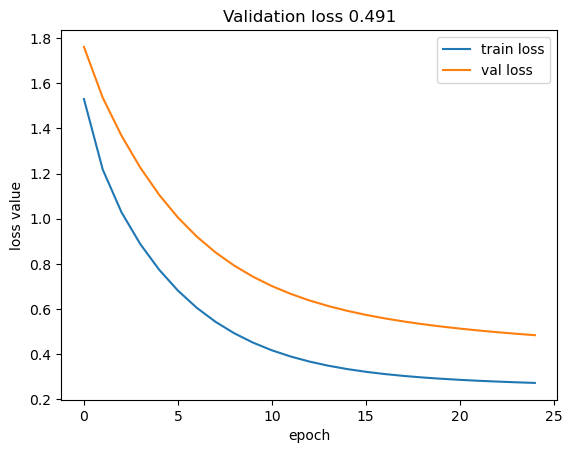

TypeError: 'value' must be an instance of str or bytes, not a tuple

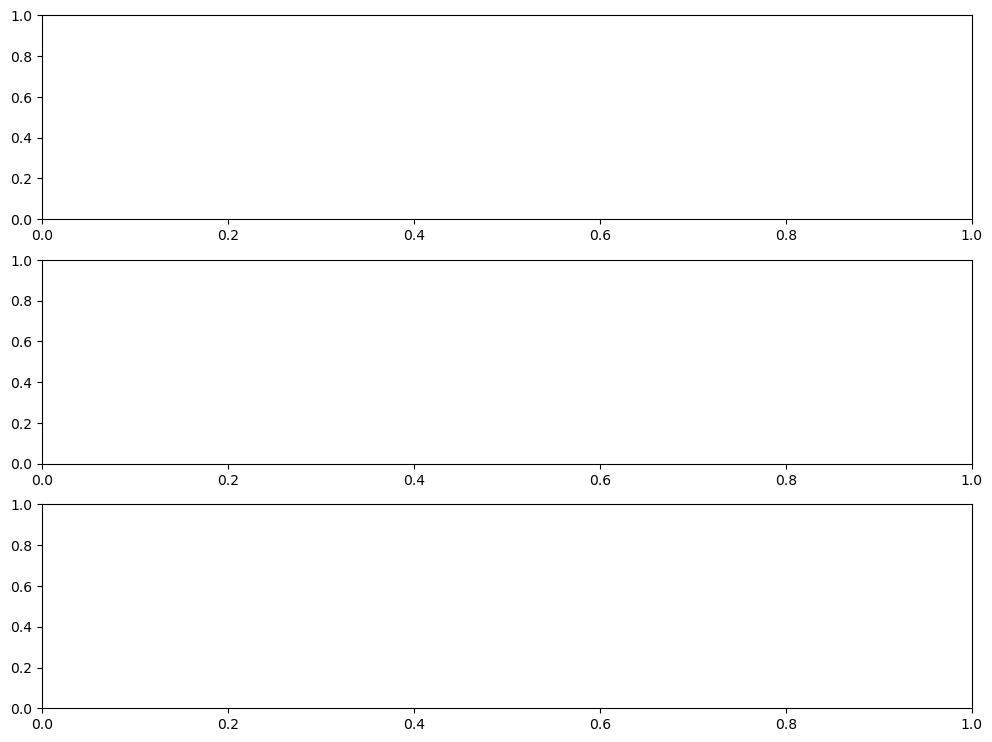

In [66]:
name = "linear"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [1],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__epochs": [25],
    },
)


def model_fun(learning_rate):
    model = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    # model.summary()
    return model


model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    # n_jobs=1,
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
plot_timeline(df_pred, name, "ENF")

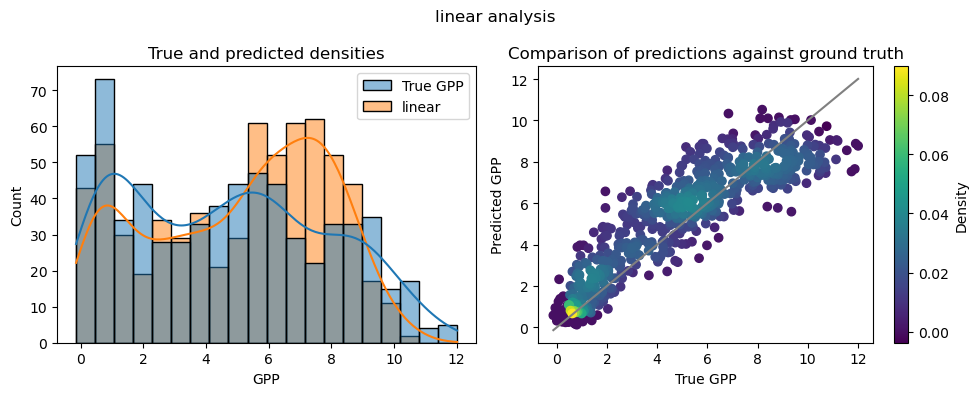

In [21]:
pred_plot(df_pred, name)

### LSTM

In [24]:
def model_fun(
    lstm_units,
    learning_rate,
    dropout=0,
    recurrent_dropout=0,
    kernel_regularizer=0,
    recurrent_regularizer=0,
    seed=0,
):
    model = tf.keras.models.Sequential(
        [
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(
                lstm_units,
                return_sequences=True,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
                recurrent_regularizer=tf.keras.regularizers.L2(recurrent_regularizer),
                # seed=seed
            ),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1),
        ]
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    # model.summary()
    return model

Fitting 1 folds for each of 4 candidates, totalling 4 fits
1/1 [==============================] - 1s 703ms/step
(2630,)
1/1 [==============================] - 0s 230ms/step
(2630,)
[CV] END regressor__reg__n=30, regressor__reg__regressor__epochs=1, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=30, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time=   6.1s
1/1 [==============================] - 1s 689ms/step
(2630,)
1/1 [==============================] - 0s 213ms/step
(2630,)
[CV] END regressor__reg__n=60, regressor__reg__regressor__epochs=1, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=30, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time=   8.0s
1/1 [==============================] - 1s 933ms/step
(2630,)
1/1 [=============

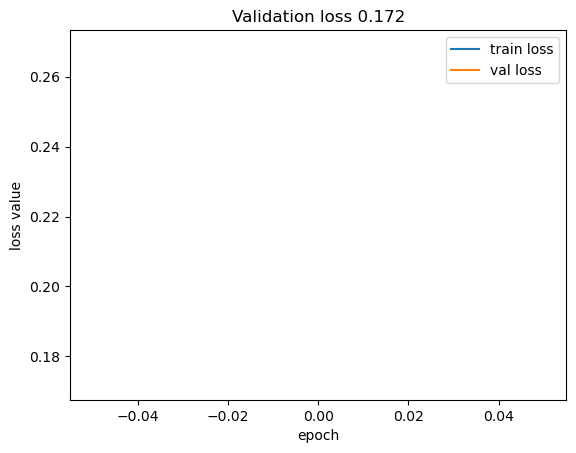

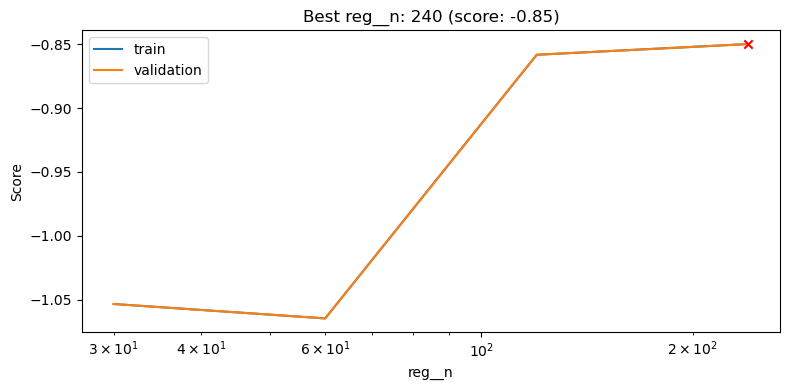

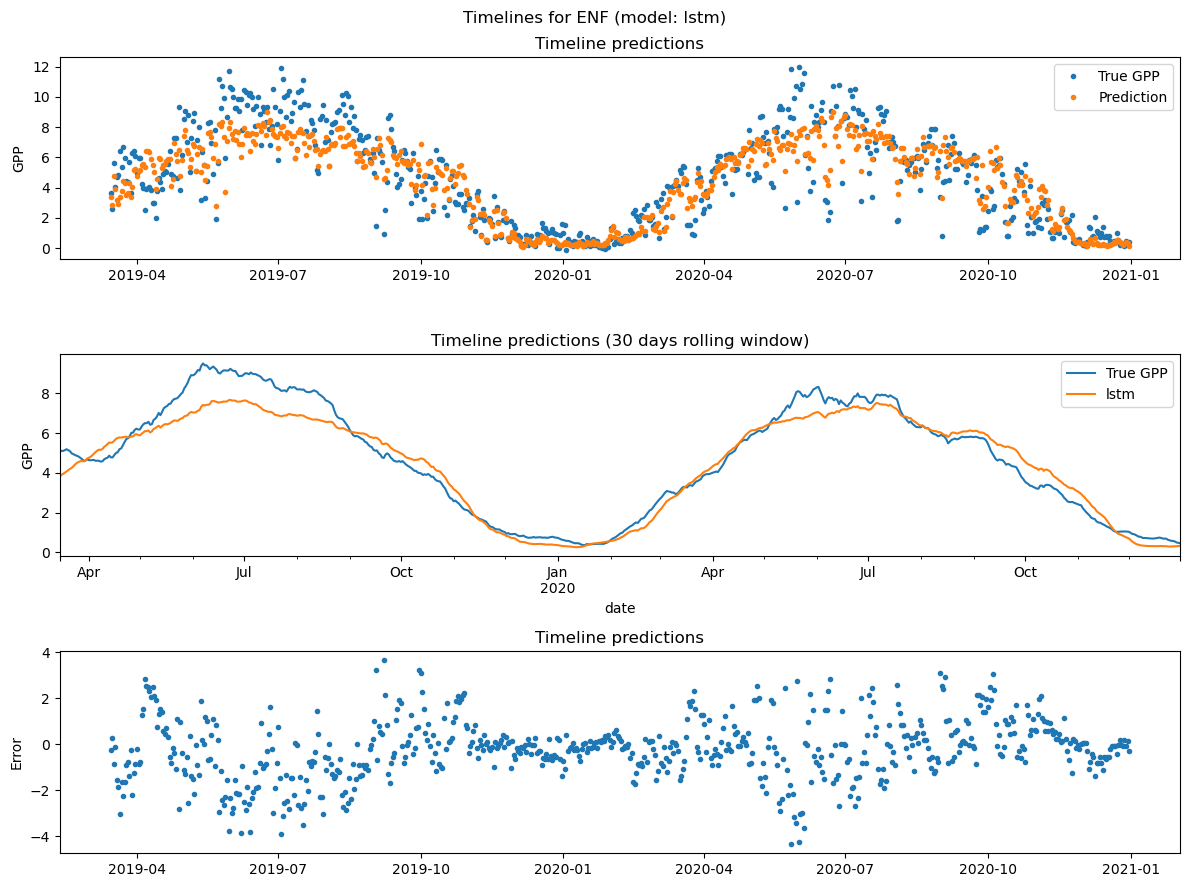

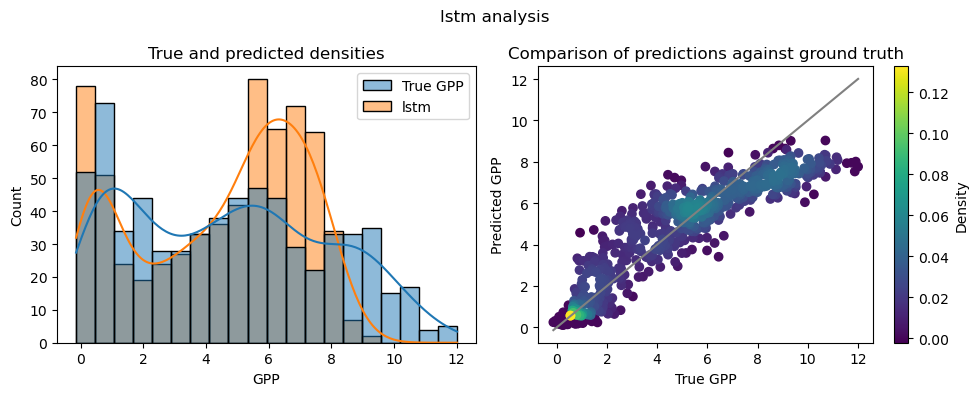

In [25]:
name = "lstm"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [30, 60, 120, 240],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [30],
        "reg__regressor__epochs": [1],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__n", xlog=True)
plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
Epoch 1/100
248/248 [==============================] - 11s 37ms/step - loss: 0.5639 - mean_absolute_error: 0.5591 - val_loss: 0.3862 - val_mean_absolute_error: 0.4919
Epoch 2/100
248/248 [==============================] - 9s 35ms/step - loss: 0.3494 - mean_absolute_error: 0.4505 - val_loss: 0.3299 - val_mean_absolute_error: 0.4431
Epoch 3/100
248/248 [==============================] - 9s 36ms/step - loss: 0.3130 - mean_absolute_error: 0.4267 - val_loss: 0.3035 - val_mean_absolute_error: 0.4248
Epoch 4/100
248/248 [==============================] - 9s 36ms/step - loss: 0.2946 - mean_absolute_error: 0.4136 - val_loss: 0.2904 - val_mean_absolute_error: 0.4187
Epoch 5/100
248/248 [==============================] - 9s 35ms/step - loss: 0.2839 - mean_absolute_error: 0.4054 - val_loss: 0.2834 - val_mean_absolute_error: 0.4179
Epoch 6/100
248/248 [==============================] - 9s 36ms/step - loss: 0.2766 - mean_absolute_error: 0.39

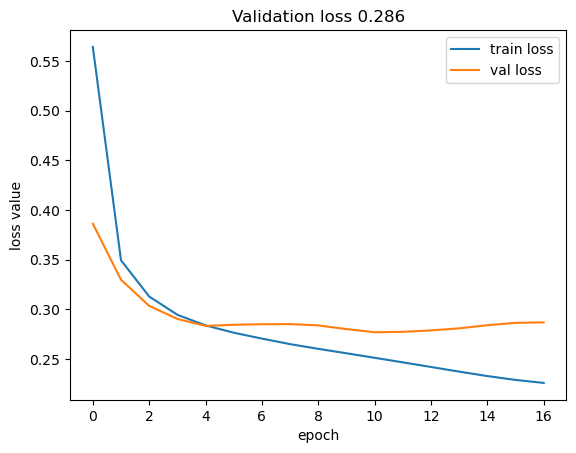

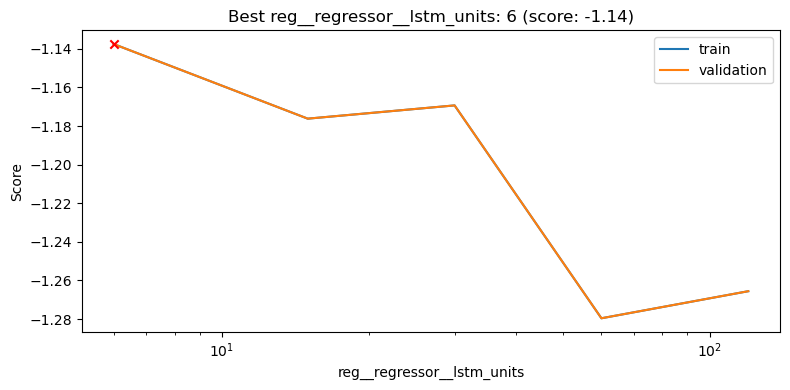

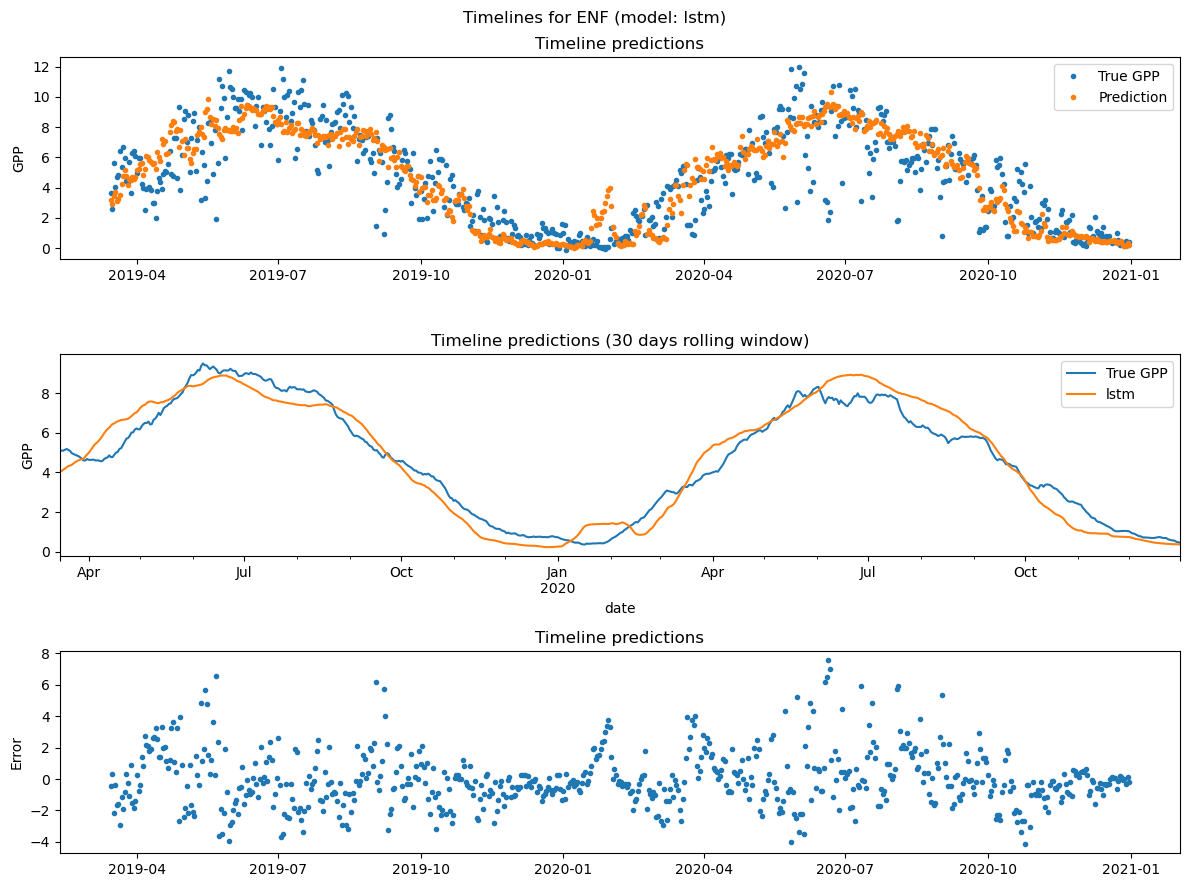

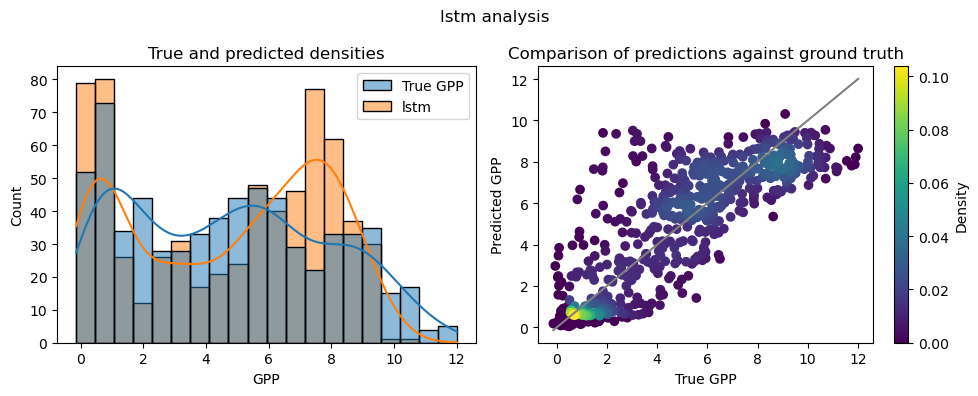

In [94]:
name = "lstm"
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [120],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [6, 15, 30, 60, 120],
        "reg__regressor__epochs": [25],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None, build_model(), grid, X_tv, y_tv, X_test, y_test, verbose=2, n_splits=0
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__regressor__lstm_units", xlog=True)
plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
Epoch 1/25
261/261 [==============================] - 4s 7ms/step - loss: 0.9820 - mean_absolute_error: 0.7467 - val_loss: 0.5485 - val_mean_absolute_error: 0.5777
Epoch 2/25
261/261 [==============================] - 1s 6ms/step - loss: 0.4901 - mean_absolute_error: 0.5229 - val_loss: 0.3698 - val_mean_absolute_error: 0.4686
Epoch 3/25
261/261 [==============================] - 2s 6ms/step - loss: 0.3969 - mean_absolute_error: 0.4778 - val_loss: 0.3215 - val_mean_absolute_error: 0.4341
Epoch 4/25
261/261 [==============================] - 1s 5ms/step - loss: 0.3591 - mean_absolute_error: 0.4557 - val_loss: 0.2911 - val_mean_absolute_error: 0.4109
Epoch 5/25
261/261 [==============================] - 1s 6ms/step - loss: 0.3364 - mean_absolute_error: 0.4406 - val_loss: 0.2731 - val_mean_absolute_error: 0.3984
Epoch 6/25
261/261 [==============================] - 2s 6ms/step - loss: 0.3219 - mean_absolute_error: 0.4309 - val_lo

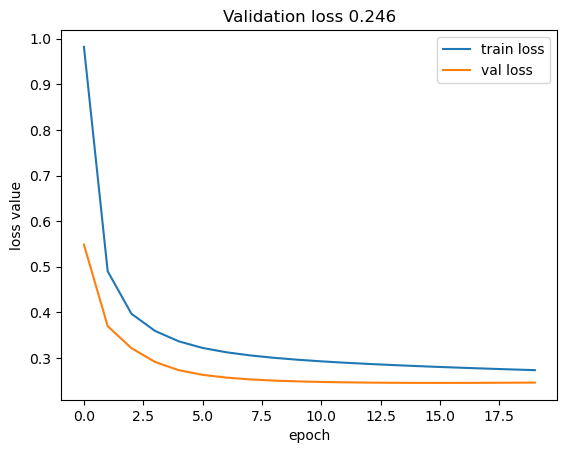

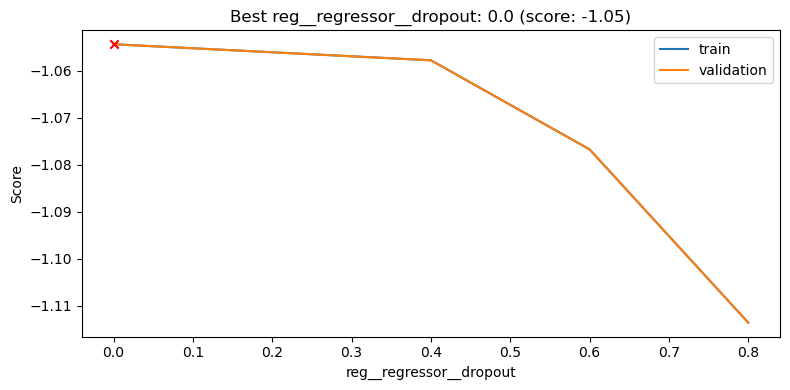

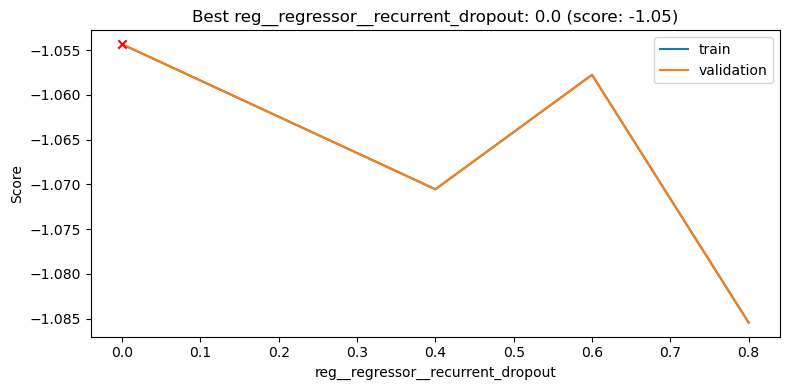

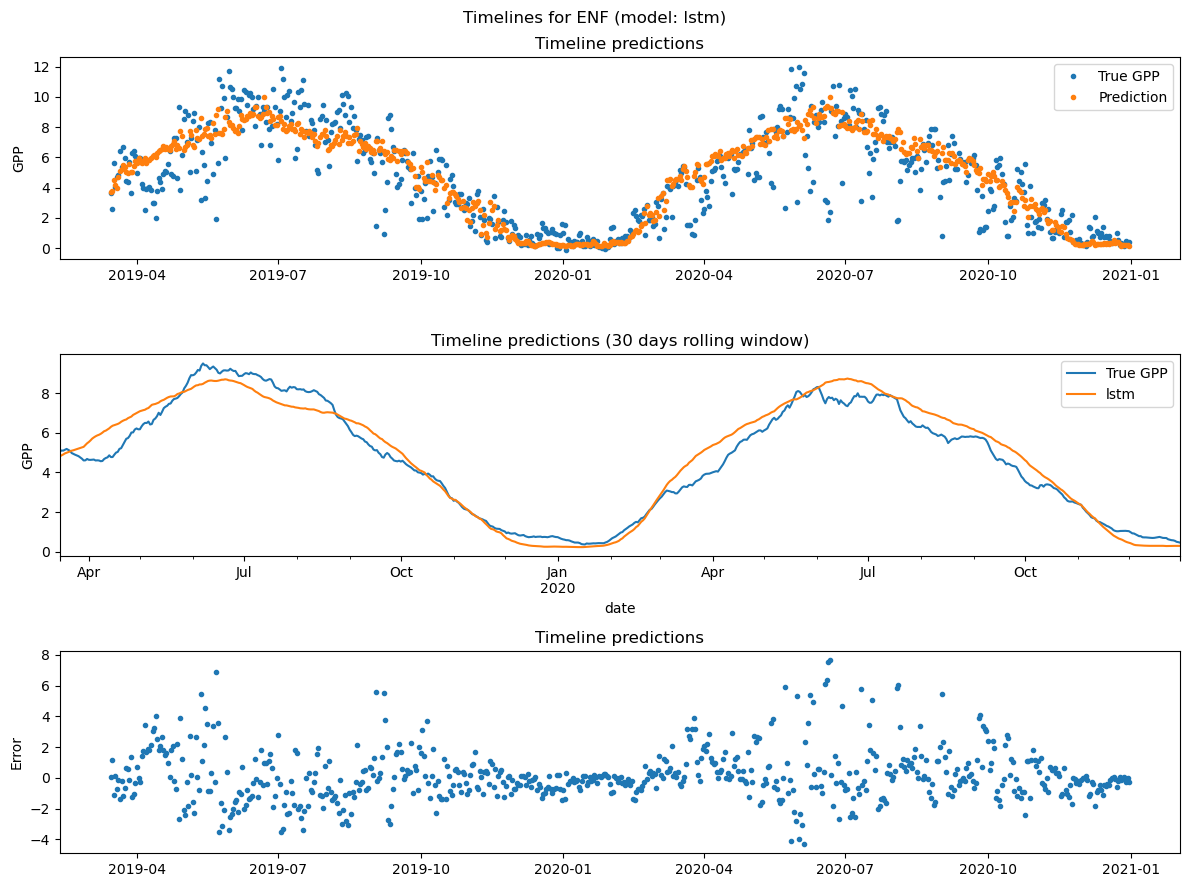

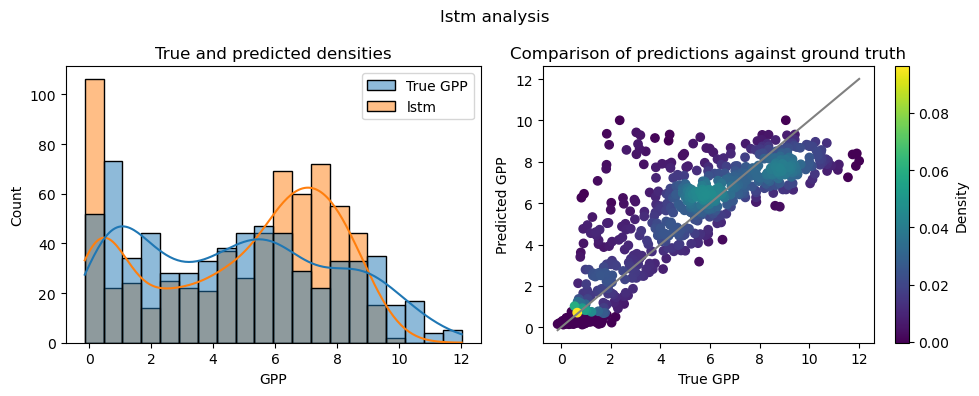

In [101]:
name = "lstm"
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [12],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [6],
        "reg__regressor__dropout": [0, 0.4, 0.6, 0.8],
        "reg__regressor__recurrent_dropout": [0, 0.4, 0.6, 0.8],
        "reg__regressor__epochs": [25],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None, build_model(), grid, X_tv, y_tv, X_test, y_test, verbose=2, n_splits=0
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__regressor__dropout", xlog=False)
hyperparam_graph(model, "reg__regressor__recurrent_dropout", xlog=False)
plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
Epoch 1/25
262/262 [==============================] - 4s 7ms/step - loss: 0.5789 - mean_absolute_error: 0.5325 - val_loss: 0.3695 - val_mean_absolute_error: 0.4451
Epoch 2/25
262/262 [==============================] - 2s 6ms/step - loss: 0.3379 - mean_absolute_error: 0.4110 - val_loss: 0.3109 - val_mean_absolute_error: 0.4159
Epoch 3/25
262/262 [==============================] - 1s 6ms/step - loss: 0.2821 - mean_absolute_error: 0.3753 - val_loss: 0.2697 - val_mean_absolute_error: 0.3850
Epoch 4/25
262/262 [==============================] - 1s 6ms/step - loss: 0.2562 - mean_absolute_error: 0.3559 - val_loss: 0.2396 - val_mean_absolute_error: 0.3597
Epoch 5/25
262/262 [==============================] - 2s 6ms/step - loss: 0.2410 - mean_absolute_error: 0.3438 - val_loss: 0.2164 - val_mean_absolute_error: 0.3397
Epoch 6/25
262/262 [==============================] - 2s 6ms/step - loss: 0.2291 - mean_absolute_error: 0.3340 - val_loss

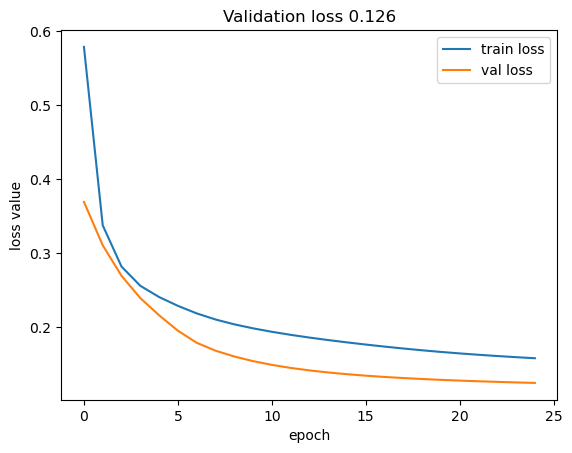

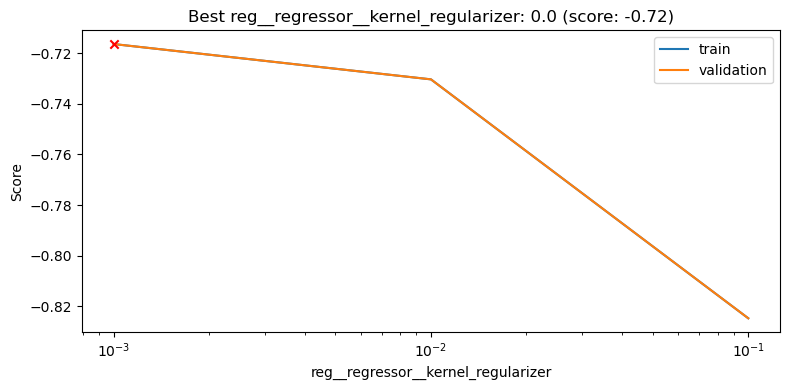

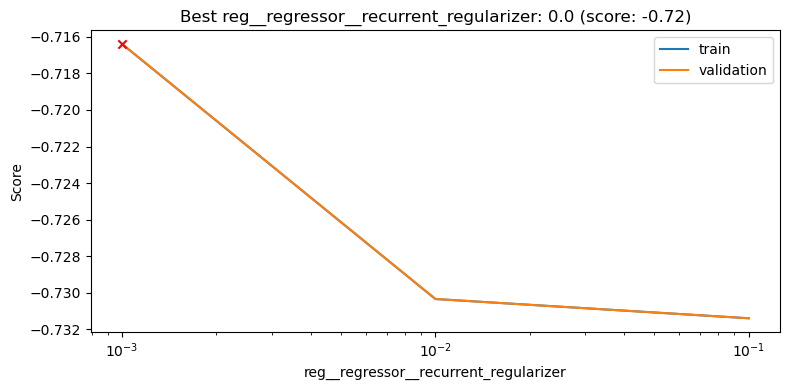

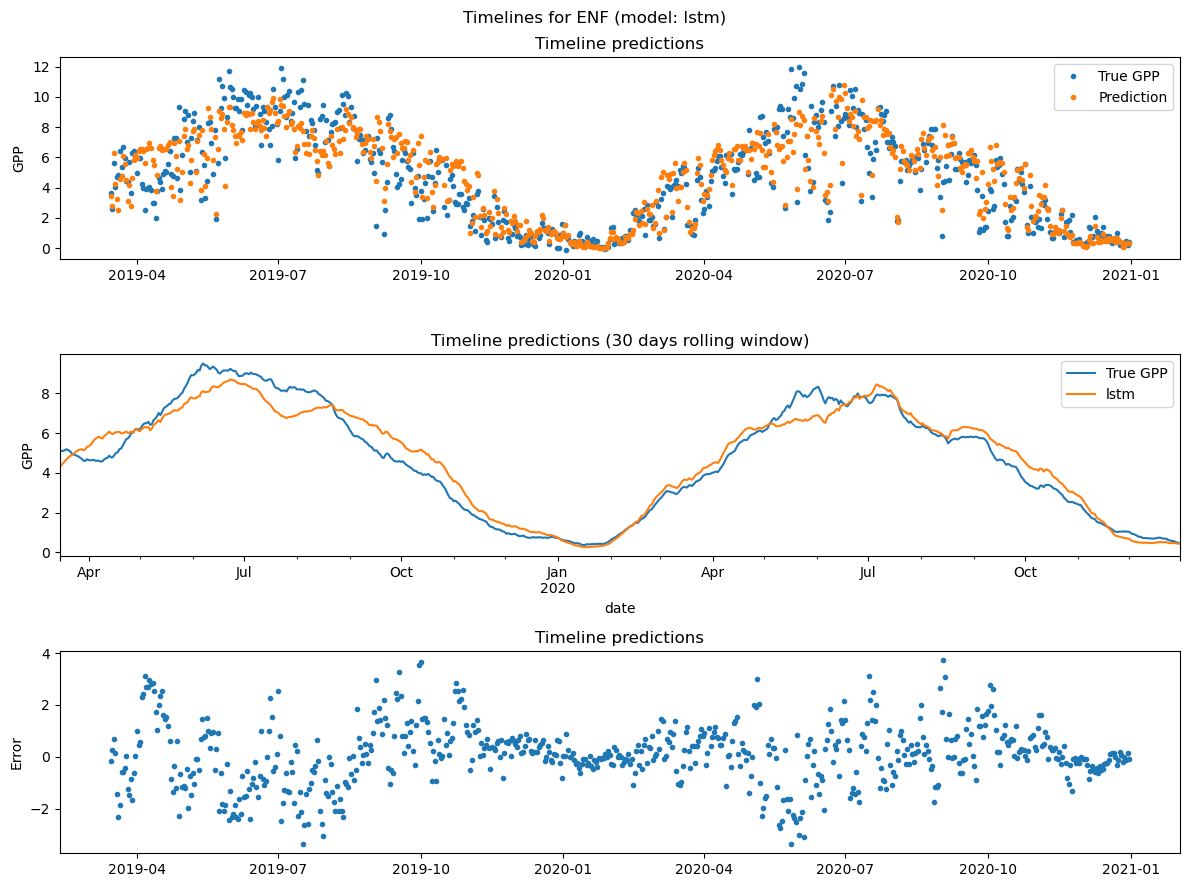

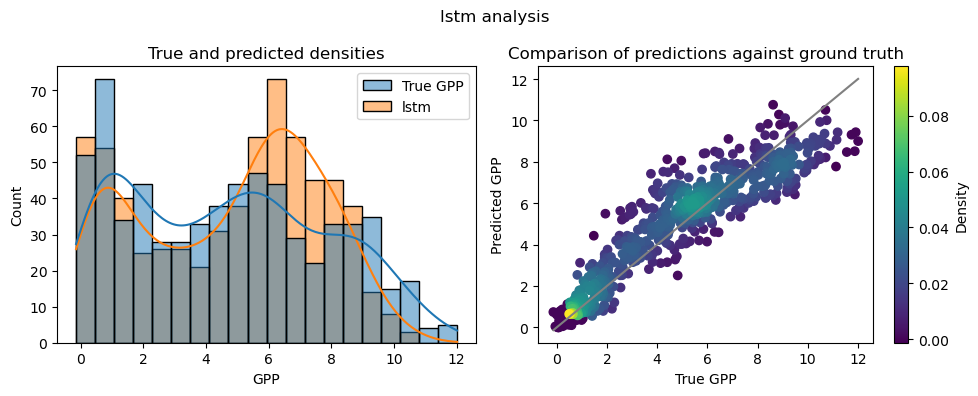

In [21]:
name = "lstm"
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [12],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [6],
        "reg__regressor__kernel_regularizer": [0.001, 0.01, 0.1],
        "reg__regressor__recurrent_regularizer": [0.001, 0.01, 0.1],
        "reg__regressor__epochs": [25],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None, build_model(), grid, X_tv, y_tv, X_test, y_test, verbose=2, n_splits=0
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__regressor__kernel_regularizer", xlog=True)
hyperparam_graph(model, "reg__regressor__recurrent_regularizer", xlog=True)
plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)

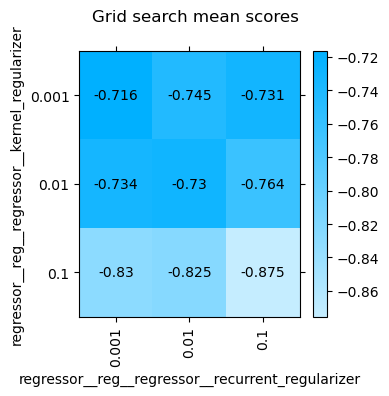

In [24]:
hyperparam_plot(
    model,
    ["reg__regressor__kernel_regularizer", "reg__regressor__recurrent_regularizer"],
    figsize=(4, 4),
)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
Epoch 1/25
255/255 [==============================] - 7s 20ms/step - loss: 1.2025 - mean_absolute_error: 0.7753 - val_loss: 0.5757 - val_mean_absolute_error: 0.5124
Epoch 2/25
255/255 [==============================] - 5s 18ms/step - loss: 0.5620 - mean_absolute_error: 0.4855 - val_loss: 0.4473 - val_mean_absolute_error: 0.4445
Epoch 3/25
255/255 [==============================] - 5s 18ms/step - loss: 0.4567 - mean_absolute_error: 0.4520 - val_loss: 0.3681 - val_mean_absolute_error: 0.4117
Epoch 4/25
255/255 [==============================] - 5s 18ms/step - loss: 0.4024 - mean_absolute_error: 0.4358 - val_loss: 0.3235 - val_mean_absolute_error: 0.3945
Epoch 5/25
255/255 [==============================] - 5s 19ms/step - loss: 0.3692 - mean_absolute_error: 0.4266 - val_loss: 0.3004 - val_mean_absolute_error: 0.3890
Epoch 6/25
255/255 [==============================] - 5s 18ms/step - loss: 0.3492 - mean_absolute_error: 0.4208 - va

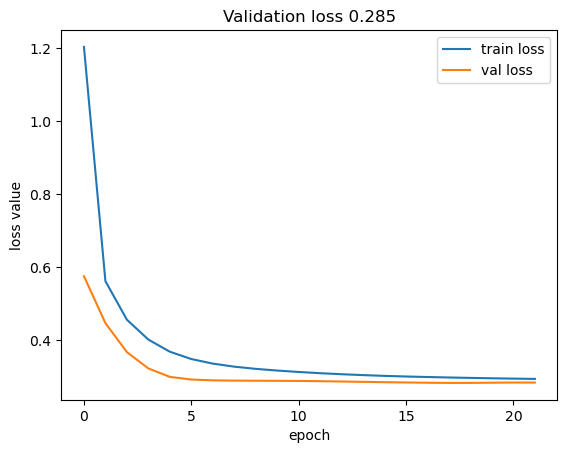

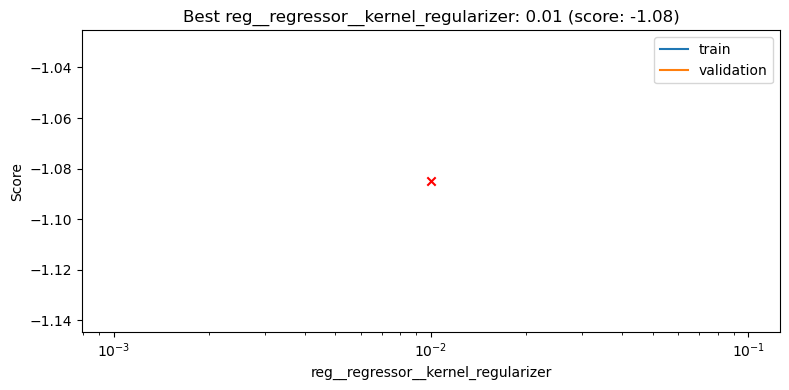

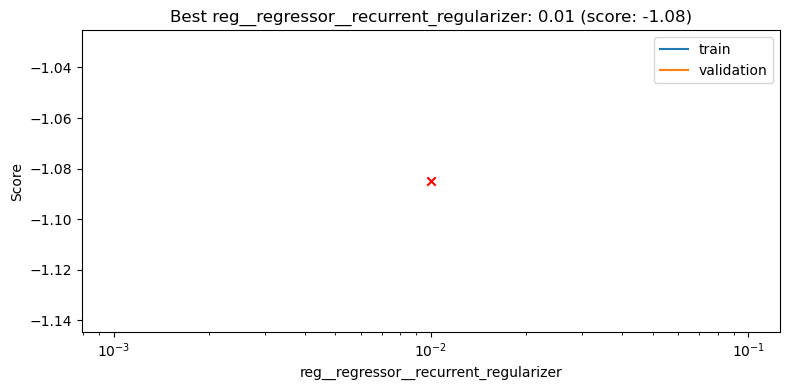

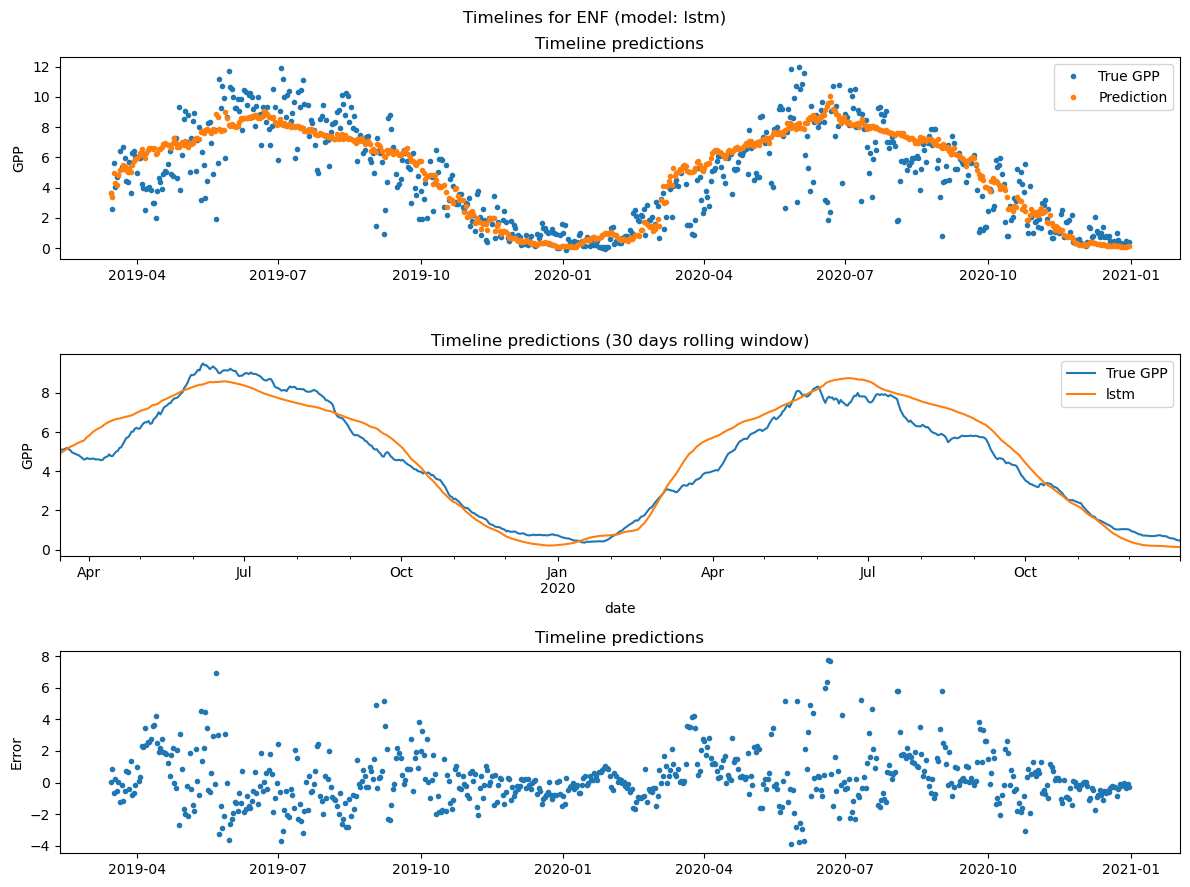

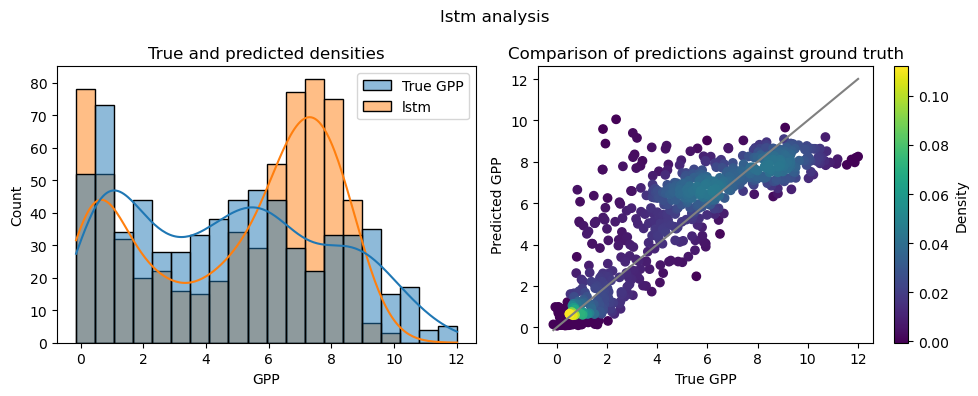

In [103]:
name = "lstm"
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [60],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [1, 2, 3, 4, 5, 6, 10, 20, 60],
        "reg__regressor__kernel_regularizer": [0.01],
        "reg__regressor__recurrent_regularizer": [0.01],
        "reg__regressor__epochs": [25],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None, build_model(), grid, X_tv, y_tv, X_test, y_test, verbose=2, n_splits=0
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__regressor__lstm_units", xlog=False)
plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)

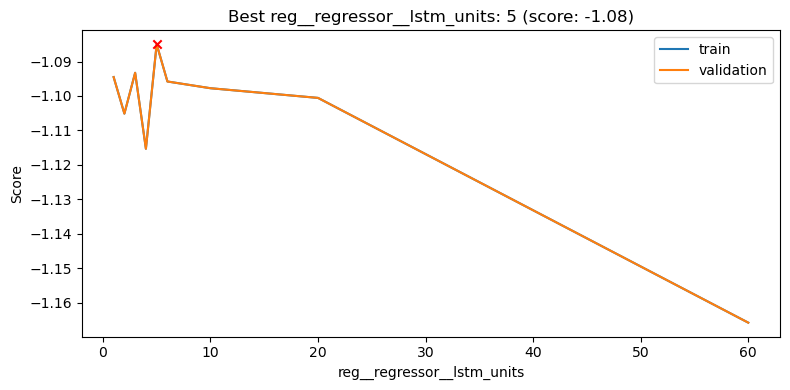

In [104]:
hyperparam_graph(model, "reg__regressor__lstm_units", xlog=False)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
Epoch 1/25
258/258 [==============================] - 5s 14ms/step - loss: 0.6669 - mean_absolute_error: 0.5241 - val_loss: 0.5177 - val_mean_absolute_error: 0.4864
Epoch 2/25
258/258 [==============================] - 3s 13ms/step - loss: 0.4917 - mean_absolute_error: 0.4664 - val_loss: 0.4180 - val_mean_absolute_error: 0.4465
Epoch 3/25
258/258 [==============================] - 3s 13ms/step - loss: 0.4216 - mean_absolute_error: 0.4388 - val_loss: 0.3714 - val_mean_absolute_error: 0.4306
Epoch 4/25
258/258 [==============================] - 3s 13ms/step - loss: 0.3840 - mean_absolute_error: 0.4261 - val_loss: 0.3445 - val_mean_absolute_error: 0.4247
Epoch 5/25
258/258 [==============================] - 3s 13ms/step - loss: 0.3615 - mean_absolute_error: 0.4196 - val_loss: 0.3275 - val_mean_absolute_error: 0.4220
Epoch 6/25
258/258 [==============================] - 3s 13ms/step - loss: 0.3471 - mean_absolute_error: 0.4164 - 

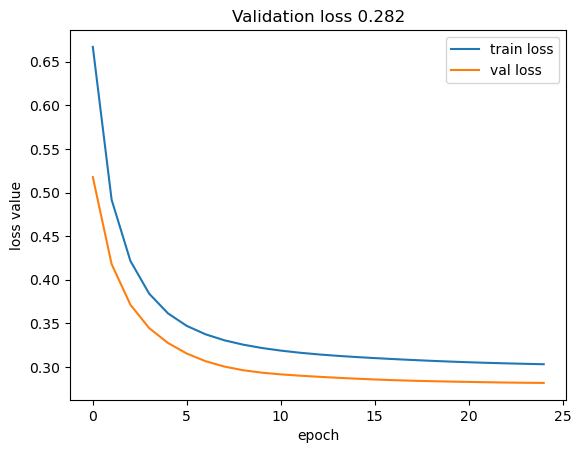

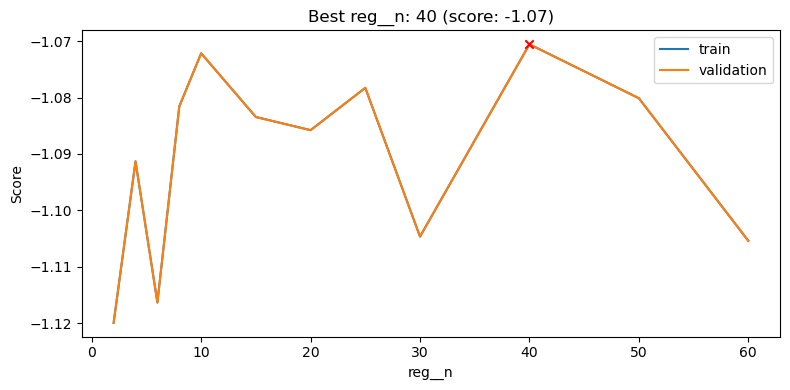

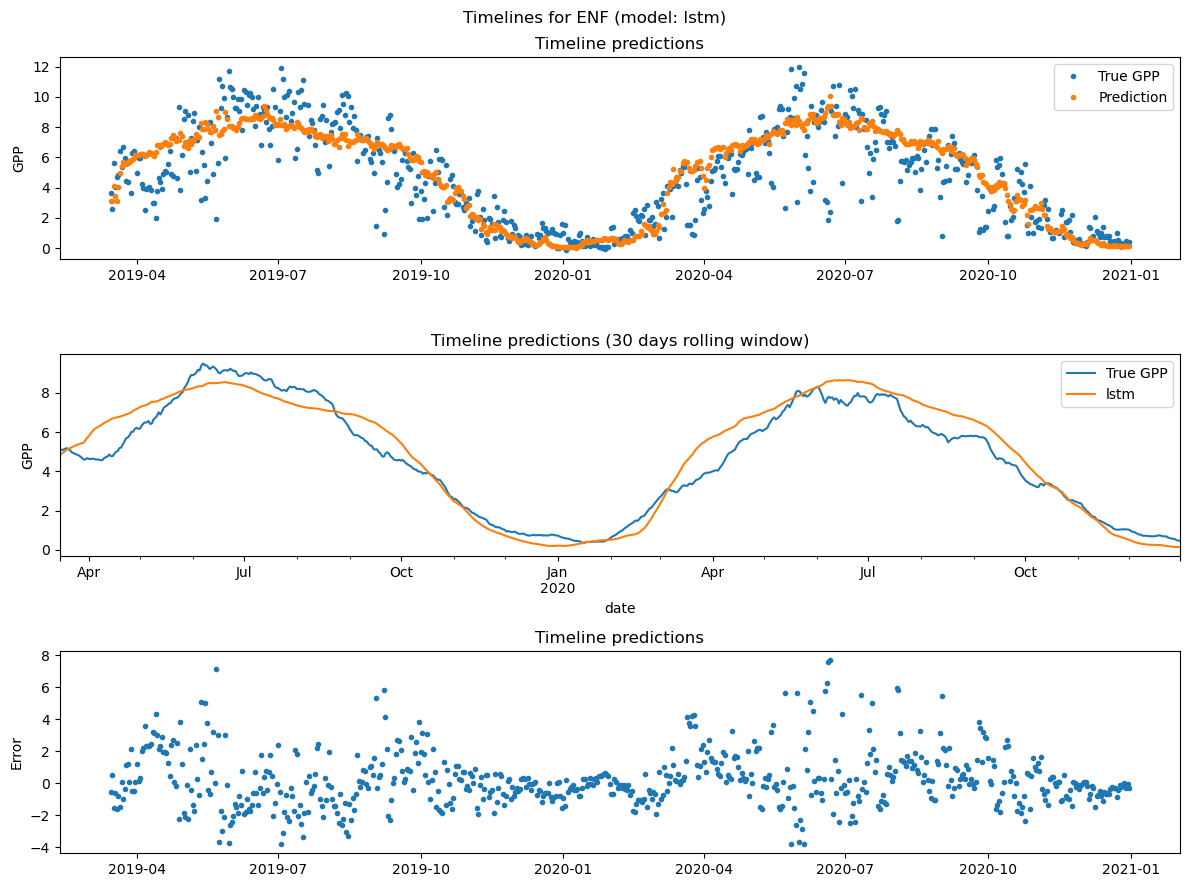

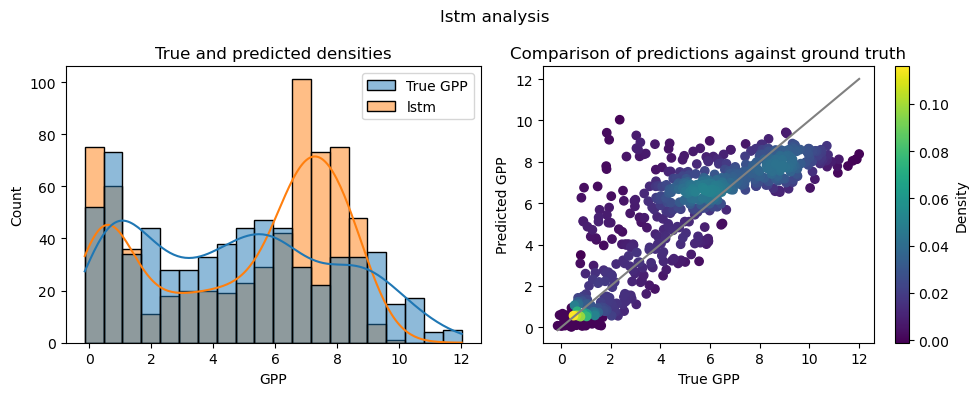

In [105]:
name = "lstm"
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, 60],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [5],
        "reg__regressor__kernel_regularizer": [0.01],
        "reg__regressor__recurrent_regularizer": [0.01],
        "reg__regressor__epochs": [25],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None, build_model(), grid, X_tv, y_tv, X_test, y_test, verbose=2, n_splits=0
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__n", xlog=False)
plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)

Fitting 1 folds for each of 2 candidates, totalling 2 fits
Epoch 1/25
262/262 [==============================] - 3s 6ms/step - loss: 0.6966 - mean_absolute_error: 0.5322 - val_loss: 0.4427 - val_mean_absolute_error: 0.4293
Epoch 2/25
262/262 [==============================] - 1s 5ms/step - loss: 0.3534 - mean_absolute_error: 0.3717 - val_loss: 0.2858 - val_mean_absolute_error: 0.3485
Epoch 3/25
262/262 [==============================] - 1s 5ms/step - loss: 0.2728 - mean_absolute_error: 0.3297 - val_loss: 0.2273 - val_mean_absolute_error: 0.3153
Epoch 4/25
262/262 [==============================] - 1s 5ms/step - loss: 0.2373 - mean_absolute_error: 0.3105 - val_loss: 0.1997 - val_mean_absolute_error: 0.2969
Epoch 5/25
262/262 [==============================] - 1s 5ms/step - loss: 0.2182 - mean_absolute_error: 0.3000 - val_loss: 0.1833 - val_mean_absolute_error: 0.2855
Epoch 6/25
262/262 [==============================] - 1s 5ms/step - loss: 0.2052 - mean_absolute_error: 0.2924 - val_loss

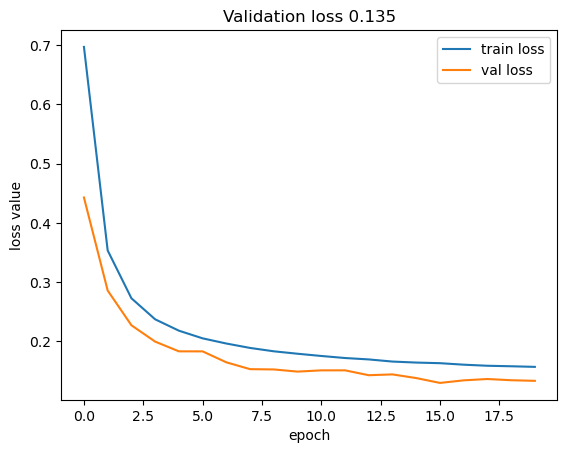

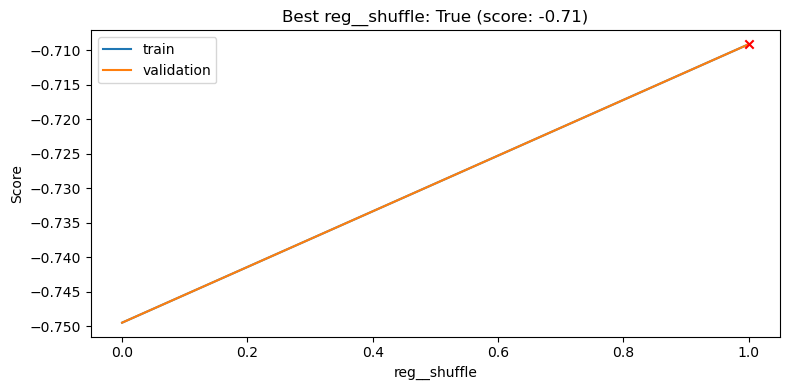

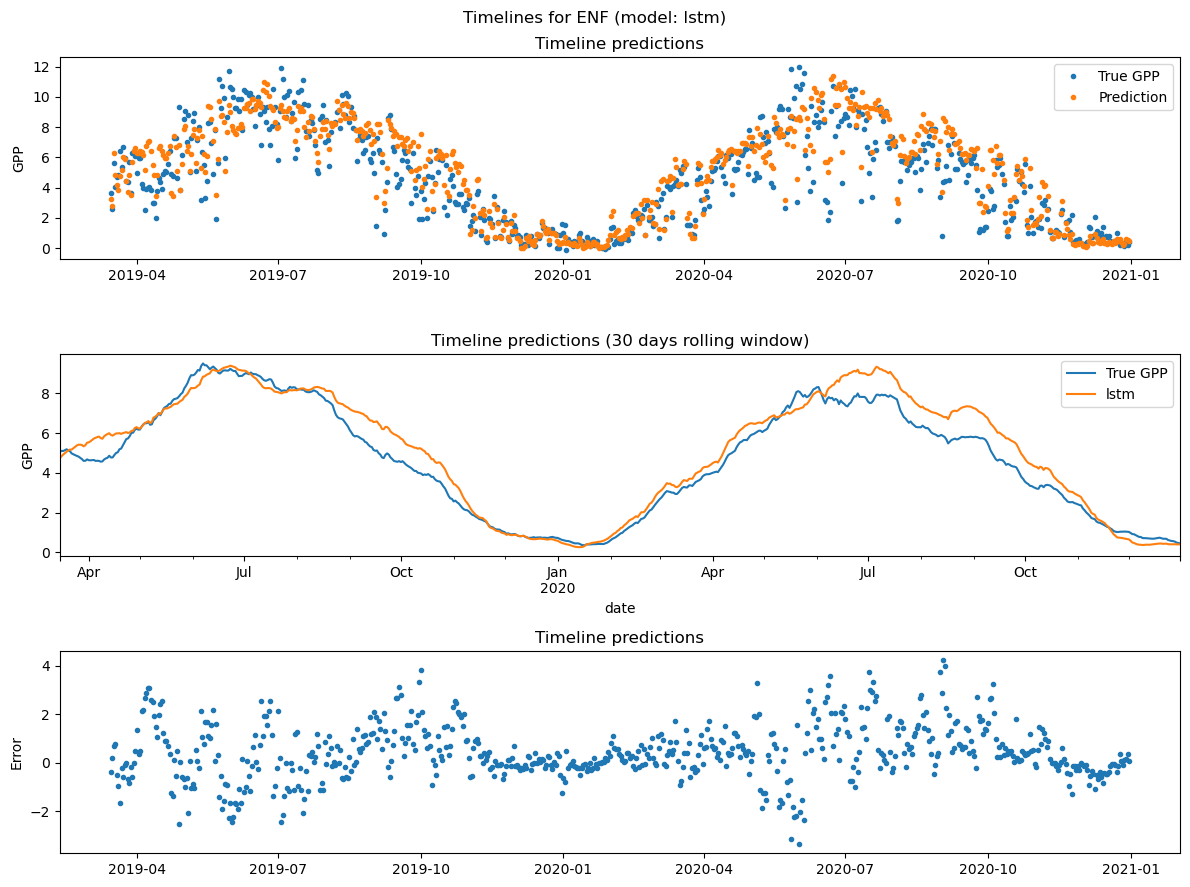

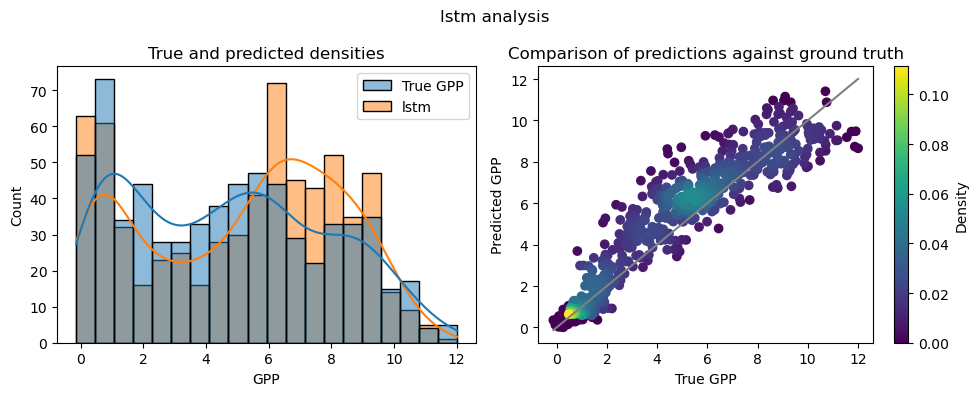

In [117]:
name = "lstm"
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [10],  # Total window size
        "reg__shuffle": [False, True],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [5],
        "reg__regressor__kernel_regularizer": [0.01],
        "reg__regressor__recurrent_regularizer": [0.01],
        "reg__regressor__epochs": [25],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None, build_model(), grid, X_tv, y_tv, X_test, y_test, verbose=2, n_splits=0
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__shuffle", xlog=False)
plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
Epoch 1/25
261/261 [==============================] - 4s 9ms/step - loss: 0.6271 - mean_absolute_error: 0.5087 - val_loss: 0.4245 - val_mean_absolute_error: 0.4224
Epoch 2/25
261/261 [==============================] - 2s 8ms/step - loss: 0.3486 - mean_absolute_error: 0.3603 - val_loss: 0.2829 - val_mean_absolute_error: 0.3544
Epoch 3/25
261/261 [==============================] - 2s 8ms/step - loss: 0.2675 - mean_absolute_error: 0.3215 - val_loss: 0.2188 - val_mean_absolute_error: 0.3135
Epoch 4/25
261/261 [==============================] - 2s 7ms/step - loss: 0.2262 - mean_absolute_error: 0.3011 - val_loss: 0.1873 - val_mean_absolute_error: 0.2913
Epoch 5/25
261/261 [==============================] - 2s 8ms/step - loss: 0.2029 - mean_absolute_error: 0.2901 - val_loss: 0.1696 - val_mean_absolute_error: 0.2793
Epoch 6/25
261/261 [==============================] - 2s 8ms/step - loss: 0.1881 - mean_absolute_error: 0.2828 - val_loss

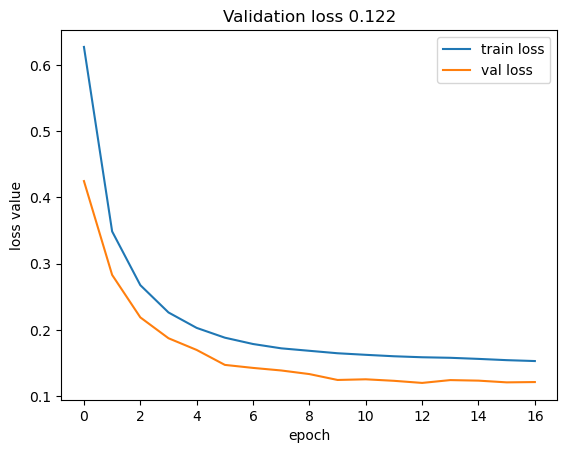

NameError: name 'display_graph' is not defined

In [21]:
name = "lstm"
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [10, 20],  # Total window size
        "reg__shuffle": [False, True],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [2, 5],
        "reg__regressor__kernel_regularizer": [0.01],
        "reg__regressor__recurrent_regularizer": [0.01],
        "reg__regressor__epochs": [25],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None, build_model(), grid, X_tv, y_tv, X_test, y_test, verbose=2, n_splits=0
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__shuffle", xlog=False)
plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)

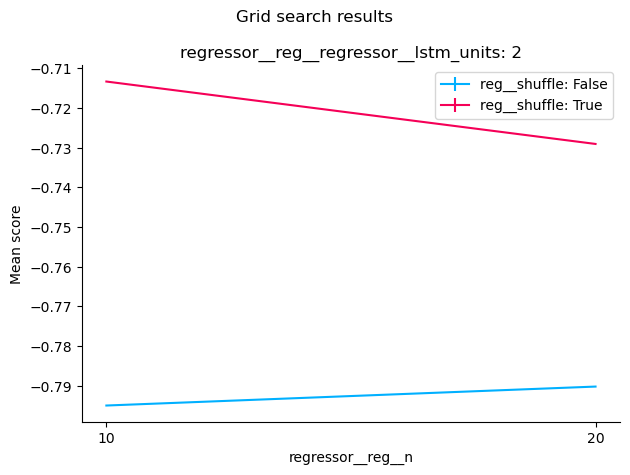

In [39]:
hyperparam_plot(model, ["reg__n"], subset={"reg__regressor__lstm_units": 2}, kind="line")

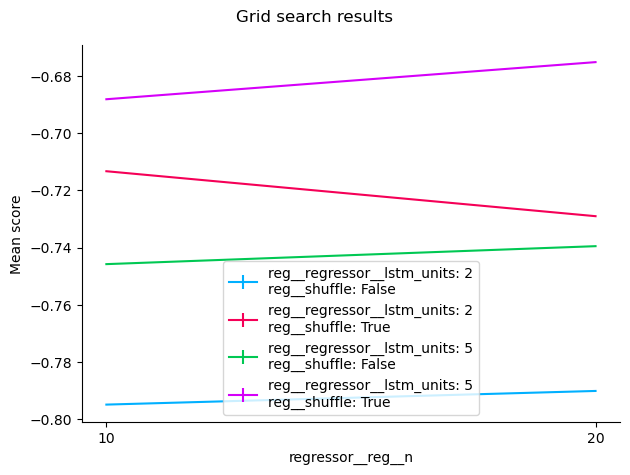

In [40]:
hyperparam_plot(model, ["reg__n"], kind="line")

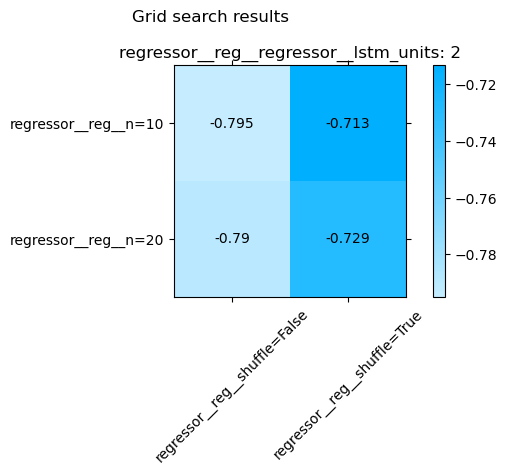

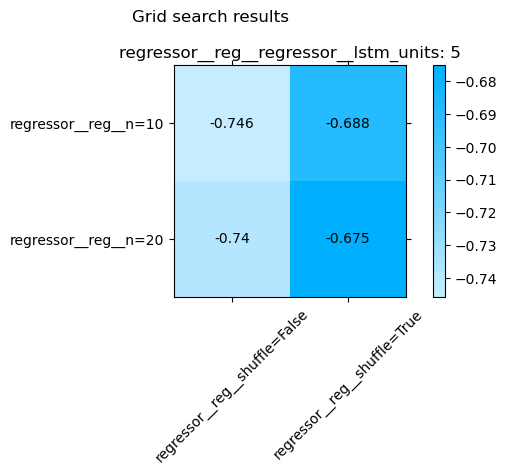

In [41]:
hyperparam_plot(
    model, ["reg__shuffle", "reg__n"], subset={"reg__regressor__lstm_units": 2}
)
hyperparam_plot(
    model, ["reg__shuffle", "reg__n"], subset={"reg__regressor__lstm_units": 5}
)

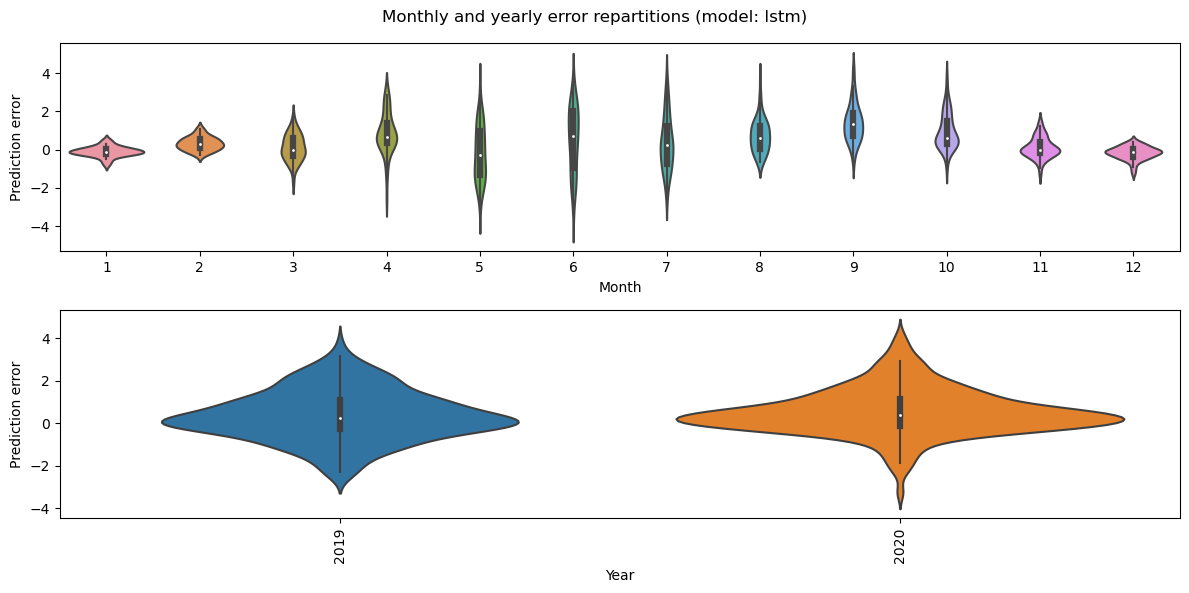

In [118]:
error_per_month_and_year(df_pred, "lstm")

In [42]:
df_pred

True GPP  baseline      lstm
date                                    
2019-03-15  3.625583  3.625583  3.086915
2019-03-16  2.559586  2.559586  2.540313
2019-03-17  5.608671  5.608671  5.974136
2019-03-18  4.058096  4.058096  4.587534
2019-03-19  4.715067  4.715067  4.049462
...              ...       ...       ...
2020-12-27  0.286723  0.286723  0.124075
2020-12-28  0.137851  0.137851  0.213875
2020-12-29  0.471447  0.471447  0.463039
2020-12-30  0.195790  0.195790  0.443992
2020-12-31  0.420926  0.420926  0.342434

[658 rows x 3 columns]

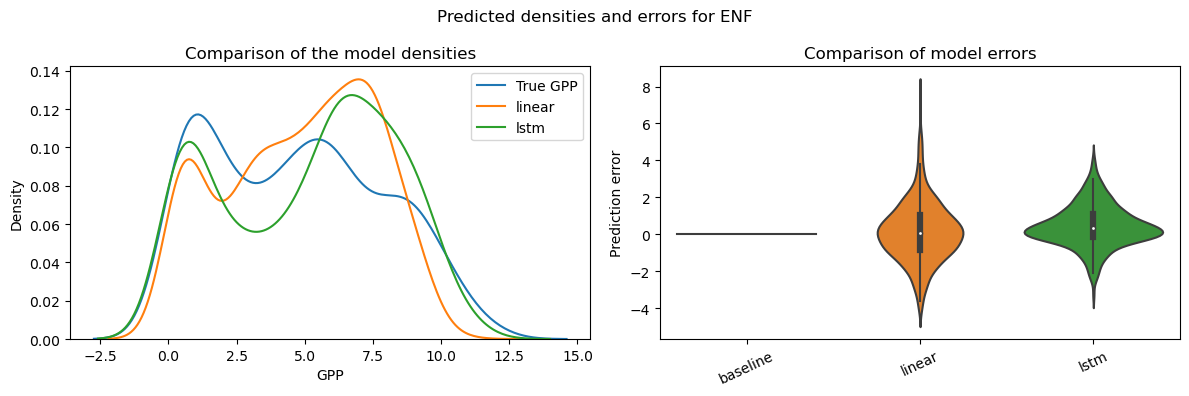

In [119]:
plot_desity_and_errors(df_pred, models=["linear", "lstm"], cover_type="ENF")

In [ ]:
TODO:
    - Check that you are not always validating with the same month
    - What about re-activating the shufling??